In [1]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [2]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [3]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [4]:
import pylogit as pl

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import

In [6]:
size = 10000
path = '/content/drive/My Drive'
data1 = pd.read_pickle(f'{path}/CMAP/london_processed_raw.pkl')

# Restore the original dataset
col = ['age', 'male', 'driving_license', 'car_ownership', 'pt_n_interchanges', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_inv',
       'dur_pt_int_total', 'dur_driving', 'cost_transit', 'cost_driving_total']
train_df = pd.DataFrame(data1['X_train'], columns=col)
train_df['mode'] = data1['Y_train']
test_df = pd.DataFrame(data1['X_test'], columns=col)
test_df['mode'] = data1['Y_test']
data1 = pd.concat([train_df, test_df])
data1['dur_pt_total'] = data1['dur_pt_access'] + data1['dur_pt_inv'] + data1['dur_pt_int_total']
data1['dur_active'] = (data1['dur_walking'] + data1['dur_cycling']) / 2
data1['mode'] = data1['mode'].replace(0, 2).replace(3, 0)

data1['young'] = (data1['age'] < 25).astype(int)
data1['old'] = (data1['age'] > 55).astype(int)
data1['hhveh_1'] = (data1['car_ownership'] == 1).astype(int)

data1 = data1[['young', 'old', 'male', 'driving_license', 'car_ownership', 'hhveh_1', 'pt_n_interchanges', 'dur_driving', 'cost_driving_total',
               'dur_pt_total', 'cost_transit', 'dur_active', 'mode']].sample(size, random_state=6)
data1 = data1.rename(columns={'driving_license': 'license', 'car_ownership': 'hhveh', 'pt_n_interchanges': 'transfer', 'dur_driving': 'auto_time',
                              'dur_pt_total': 'transit_time', 'dur_active': 'active_time', 'cost_driving_total': 'auto_cost',
                              'cost_transit': 'transit_cost'})

var, alt = 'auto_cost', 0

In [7]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [8]:
train_size = int(size*.7)
val_size = int(size*.1)
test_size = size - train_size - val_size

data_train, data_remain = data[:train_size], data[train_size:]
data_val, data_test = data_remain[:val_size], data_remain[val_size:]

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [9]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [10]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [11]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [13]:
l_alt = ['Auto', 'Transit', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [14]:
# Training set
true_share(data_train)

mode
Auto       0.443
Transit    0.351
Active     0.205
Name: proportion, dtype: float64

In [15]:
# Validation set
true_share(data_val)

mode
Auto       0.445
Transit    0.354
Active     0.201
Name: proportion, dtype: float64

In [16]:
# Test set
true_share(data_test)

mode
Auto       0.453
Transit    0.330
Active     0.217
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [17]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'transit', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:7]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'transit_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'transit_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_transit', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [18]:
data1_train, data1_remain = data1[:train_size], data1[train_size:]
data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]

In [19]:
data1_train_lg = convert(data1_train)
data1_train_lg

obs_id  alt_id  mode  young  old  male  license  hhveh  hhveh_1  \
0           1       0     0      0    0     0        0      0        0   
1           1       1     1      0    0     0        0      0        0   
2           1       2     0      0    0     0        0      0        0   
3           2       0     0      0    0     1        1      2        0   
4           2       1     0      0    0     1        1      2        0   
...       ...     ...   ...    ...  ...   ...      ...    ...      ...   
20995    6999       1     0      0    0     1        1      0        0   
20996    6999       2     1      0    0     1        1      0        0   
20997    7000       0     1      1    0     0        0      0        0   
20998    7000       1     0      1    0     0        0      0        0   
20999    7000       2     0      1    0     0        0      0        0   

       transfer      time   cost  
0             0  0.255278  11.09  
1             0  0.527778   1.50  
2             0  0.535139   0.00  
3             0  0.053333   0.13  
4             0  0.120000   1.50  
...         ...       ...    ...  
20995         0  0.075833   1.50  
20996         0  0.056528   0.00  
20997         1  0.361111   1.04  
20998         1  0.728889   1.50  
20999         1  0.854861   0.00  

[21000 rows x 12 columns]

## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [20]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_transit', 'asc_active']

# Individual-specific variables
spec['young'] = [1, 2]
name['young'] = ['young_transit', 'young_active']
spec['old'] = [1, 2]
name['old'] = ['old_transit', 'old_active']
spec['male'] = [1, 2]
name['male'] = ['male_transit', 'male_active']
spec['license'] = [1, 2]
name['license'] = ['license_transit', 'license_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_transit', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_transit', 'hhveh_1_active']
spec['transfer'] = [1, 2]
name['transfer'] = ['transfer_transit', 'transfer_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_transit', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_transit']

In [21]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(21))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.91 seconds.
Final log-likelihood: -4,834.6935


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,979
Method:                                MLE   Df Model:                           21
Date:                     Sun, 07 Apr 2024   Pseudo R-squ.:                   0.371
Time:                             02:35:33   Pseudo R-bar-squ.:               0.369
AIC:                             9,711.387   Log-Likelihood:             -4,834.693
BIC:                             9,855.314   LL-Null:                    -7,690.286
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
asc_transit          1.9280      0.133     14.532      0.000       1.668       2.188
asc_active           3.2011      0.138     23.190      0.000       2.931       3.472
young_transit        0.0874      0.109      0.799      0.424      -0.127       0.302
young_active        -0.2253      0.116     -1.937      0.053      -0.453       0.003
old_transit          0.2118      0.103      2.056      0.040       0.010       0.414
old_active          -0.5606      0.101     -5.554      0.000      -0.758      -0.363
male_transit        -0.1055      0.071     -1.487      0.137      -0.244       0.034
male_active          0.2611      0.078      3.353      0.001       0.108       0.414
license_transit     -1.0961      0.095    -11.502      0.000      -1.283      -0.909
license_active      -0.5274      0.105     -5.019      0.000      -0.733      -0.321
hhveh_transit       -1.5897      0.059    -26.882      0.000      -1.706      -1.474
hhveh_active        -1.3328      0.064    -20.802      0.000      -1.458      -1.207
hhveh_1_transit     -0.8171      0.074    -10.980      0.000      -0.963      -0.671
hhveh_1_active      -0.7101      0.082     -8.649      0.000      -0.871      -0.549
transfer_transit    -0.2719      0.089     -3.049      0.002      -0.447      -0.097
transfer_active      0.2919      0.147      1.988      0.047       0.004       0.580
time_auto           -5.5803      0.333    -16.772      0.000      -6.232      -4.928
time_transit        -2.4305      0.231    -10.503      0.000      -2.884      -1.977
time_active         -7.3649      0.253    -29.158      0.000      -7.860      -6.870
cost_auto           -0.1652      0.015    -11.116      0.000      -0.194      -0.136
cost_transit        -0.0566      0.036     -1.574      0.115      -0.127       0.014
====================================================================================
"""

## Mixed logit (MXL)

In [22]:
# mix_var = ['time_auto', 'time_train', 'time_active', 'cost_auto', 'cost_train']

# mxl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='Mixed Logit', names=name, mixing_id_col='obs_id', mixing_vars=mix_var)
# mxl.fit_mle(np.zeros(26), num_draws=100, seed=13)
# mxl.get_statsmodels_summary()

## Results

In [23]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [24]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [25]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<7.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<7.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<7.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [26]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -4834.7 | acc = 71.8% | F1 = 71.4%
Validation set: LL = -670.0  | acc = 73.5% | F1 = 73.0%
Test set:       LL = -1366.9 | acc = 73.0% | F1 = 72.6%


In [27]:
# MXL model
# met_train_mxl = dcm_performance(mxl.predict(data1_train_lg, num_draws=500, seed=13), data1_train)
# met_val_mxl = dcm_performance(mxl.predict(data1_val_lg, num_draws=500, seed=13), data1_val)
# met_test_mxl = dcm_performance(mxl.predict(data1_test_lg, num_draws=500, seed=13), data1_test)
# print_metrics(met_train_mxl, met_val_mxl, met_test_mxl)

In [28]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [29]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} (£)')
    plt.ylabel('Probability')
    # plt.show()
    plt.savefig(f'{path}/Regularity_results_L/{name}_10K_L.png', bbox_inches='tight', dpi=200)

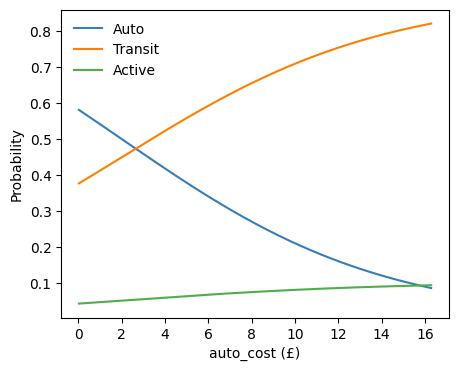

In [30]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [31]:
# MXL model
# l_prb_MXL = mxl.predict(data1_prb_lg, num_draws=500, seed=13).reshape(len(data1_prb), 3)
# RUM_sub(l_prb_MXL, 'MXL')

In [32]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [33]:
eps = (lower1 - upper1) / 5e5

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [34]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 0.996
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 0.991
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.993
Weak regularity   = 1.000


In [35]:
# MXL model
# print('Training set:')
# prb_reg = mxl.predict(data1_train_reg_lg, num_draws=500, seed=13).reshape(2*train_size, 3)[:, alt]
# met_train_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nValidation set:')
# prb_reg = mxl.predict(data1_val_reg_lg, num_draws=500, seed=13).reshape(2*val_size, 3)[:, alt]
# met_val_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nTest set:')
# prb_reg = mxl.predict(data1_test_reg_lg, num_draws=500, seed=13).reshape(2*test_size, 3)[:, alt]
# met_test_mxl.extend(cal_reg(prb_reg))

In [36]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

# results_train = pd.DataFrame({'MNL': met_train_mnl, 'MXL': met_train_mxl}, index=l_index)
# results_val = pd.DataFrame({'MNL': met_val_mnl, 'MXL': met_val_mxl}, index=l_index)
# results_test = pd.DataFrame({'MNL': met_test_mnl, 'MXL': met_test_mxl}, index=l_index)

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [37]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 9:11]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 11]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 9:11]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 11]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 9:11]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 11]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [38]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [39]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [40]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [41]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [42]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [43]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [44]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} (£)')
    plt.ylabel('Probability')
    if GR == 'none':
        plt.savefig(f'{path}/Regularity_results_L/{NN.__name__}_10K_L.png', bbox_inches='tight', dpi=200)
    else:
        plt.savefig(f'{path}/Regularity_results_L/{NN.__name__}_{base}_{GR}_{lambd}_10K_L.png', bbox_inches='tight', dpi=200)
    plt.show()

In [45]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [46]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)
    fig.savefig(f'{path}/Regularity_results_L/{NN.__name__}_{base}_{GR}_10K_L.png', bbox_inches='tight', dpi=200)

In [47]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+20, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## Deep neural networks (DNNs)

In [48]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(12, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4425.2 | acc = 73.5% | F1 = 73.3%
Validation set: LL = -643.6  | acc = 72.1% | F1 = 71.8%
Test set:       LL = -1290.1 | acc = 72.9% | F1 = 72.7%
Model 2 
Training set:   LL = -4457.4 | acc = 73.1% | F1 = 73.1%
Validation set: LL = -645.9  | acc = 72.2% | F1 = 72.2%
Test set:       LL = -1293.9 | acc = 72.5% | F1 = 72.4%
Model 3 
Training set:   LL = -4451.7 | acc = 72.6% | F1 = 72.6%
Validation set: LL = -652.1  | acc = 72.5% | F1 = 72.4%
Test set:       LL = -1311.3 | acc = 72.4% | F1 = 72.3%
Model 4 
Training set:   LL = -4432.2 | acc = 72.8% | F1 = 72.8%
Validation set: LL = -650.1  | acc = 71.8% | F1 = 71.8%
Test set:       LL = -1289.0 | acc = 73.2% | F1 = 73.1%
Model 5 
Training set:   LL = -4420.7 | acc = 73.5% | F1 = 73.3%
Validation set: LL = -648.1  | acc = 72.1% | F1 = 71.8%
Test set:       LL = -1287.8 | acc = 73.7% | F1 = 73.4%
Model 6 
Training set:   LL = -4393.4 | acc = 73.5% | F1 = 73.3%
Validat

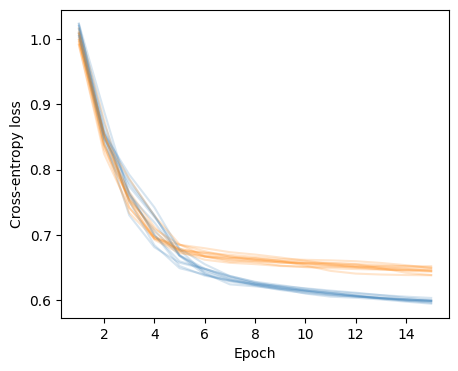

------------------------------ 
Training set:
Average log-likelihood = -4427.9 (20.6)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 73.1% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -645.5 (4.4)
Average accuracy       = 72.1% (0.2%)
Average F1 score       = 71.9% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1292.0 (7.9)
Average accuracy       = 72.9% (0.5%)
Average F1 score       = 72.7% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.032)
Weak regularity   = 0.968 (0.025)
------------------------------ 
Validation set:
Strong regularity = 0.947 (0.032)
Weak regularity   = 0.971 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.950 (0.034)
Weak regularity   = 0.969 (0.027)
------------------------------


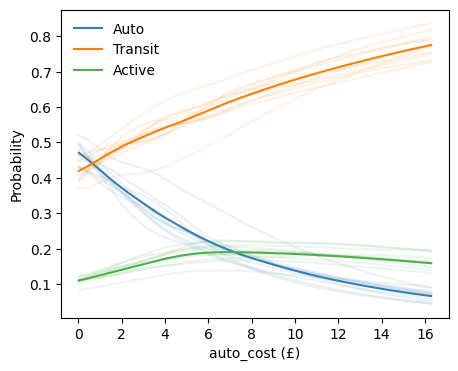

In [49]:
result(DNN, 15, 'none')

### PGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5498.6 | acc = 64.8% | F1 = 57.4%
Validation set: LL = -772.2  | acc = 66.2% | F1 = 58.9%
Test set:       LL = -1580.9 | acc = 64.7% | F1 = 57.4%
Model 2 
Training set:   LL = -5574.4 | acc = 64.8% | F1 = 59.6%
Validation set: LL = -783.7  | acc = 64.7% | F1 = 59.5%
Test set:       LL = -1600.5 | acc = 63.9% | F1 = 58.8%
Model 3 
Training set:   LL = -5843.0 | acc = 63.7% | F1 = 56.3%
Validation set: LL = -818.4  | acc = 64.4% | F1 = 57.1%
Test set:       LL = -1674.6 | acc = 62.6% | F1 = 54.8%
Model 4 
Training set:   LL = -5450.3 | acc = 64.4% | F1 = 57.0%
Validation set: LL = -768.7  | acc = 64.7% | F1 = 57.4%
Test set:       LL = -1573.4 | acc = 63.0% | F1 = 55.4%
Model 5 
Training set:   LL = -5845.0 | acc = 62.8% | F1 = 55.6%
Validation set: LL = -816.8  | acc = 63.9% | F1 = 56.8%
Test set:       LL = -1674.9 | acc = 61.0% | F1 = 53.5%
Model 6 
Training set:   LL = -5669.1 | acc = 64.2% | F1 = 56.7%
Valid

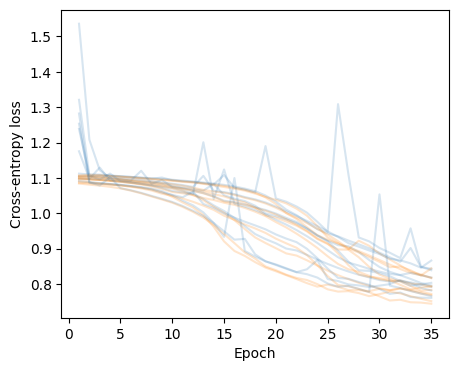

------------------------------ 
Training set:
Average log-likelihood = -5621.2 (225.0)
Average accuracy       = 64.0% (1.2%)
Average F1 score       = 57.1% (1.7%)
------------------------------ 
Validation set:
Average log-likelihood = -788.7 (29.7)
Average accuracy       = 65.0% (1.3%)
Average F1 score       = 58.1% (1.6%)
------------------------------ 
Test set:
Average log-likelihood = -1618.9 (63.1)
Average accuracy       = 63.1% (1.5%)
Average F1 score       = 55.9% (2.1%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


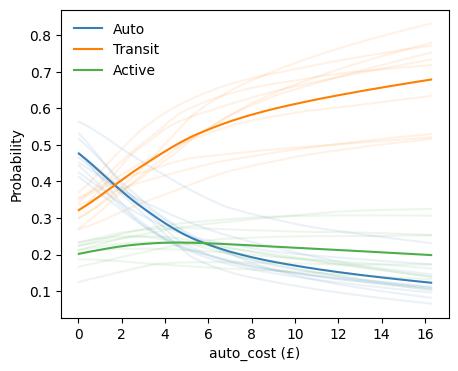

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4763.2 | acc = 71.5% | F1 = 71.0%
Validation set: LL = -667.2  | acc = 72.5% | F1 = 71.8%
Test set:       LL = -1373.3 | acc = 71.6% | F1 = 71.2%
Model 2 
Training set:   LL = -4947.8 | acc = 70.2% | F1 = 69.1%
Validation set: LL = -697.4  | acc = 69.9% | F1 = 68.7%
Test set:       LL = -1432.8 | acc = 69.8% | F1 = 68.9%
Model 3 
Training set:   LL = -4890.6 | acc = 70.8% | F1 = 69.6%
Validation set: LL = -699.4  | acc = 70.3% | F1 = 68.5%
Test set:       LL = -1429.1 | acc = 68.9% | F1 = 67.5%
Model 4 
Training set:   LL = -4689.9 | acc = 72.3% | F1 = 71.6%
Validation set: LL = -669.3  | acc = 71.3% | F1 = 70.3%
Test set:       LL = -1370.6 | acc = 72.0% | F1 = 71.4%
Model 5 
Training set:   LL = -4728.2 | acc = 71.5% | F1 = 70.8%
Validation set: LL = -673.3  | acc = 71.3% | F1 = 70.2%
Test set:       LL = -1384.5 | acc = 70.6% | F1 = 70.0%
Model 6 
Training set:   LL = -4674.6 | acc = 71.3% | F1 = 70.2%
Valida

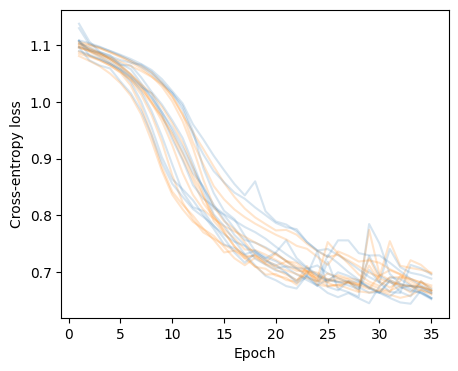

------------------------------ 
Training set:
Average log-likelihood = -4758.6 (86.4)
Average accuracy       = 71.4% (0.5%)
Average F1 score       = 70.6% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -674.3 (12.8)
Average accuracy       = 71.2% (0.7%)
Average F1 score       = 70.1% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1384.9 (23.9)
Average accuracy       = 70.6% (0.8%)
Average F1 score       = 69.9% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


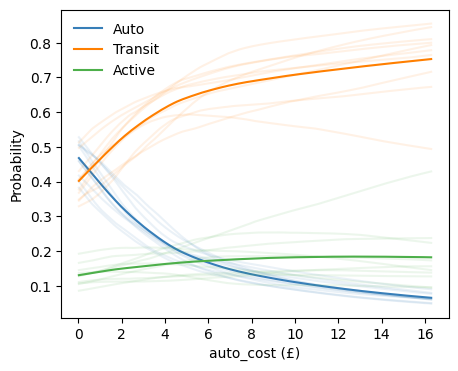

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4708.3 | acc = 71.9% | F1 = 71.3%
Validation set: LL = -659.4  | acc = 72.8% | F1 = 71.9%
Test set:       LL = -1354.2 | acc = 71.2% | F1 = 70.6%
Model 2 
Training set:   LL = -4688.4 | acc = 71.6% | F1 = 70.6%
Validation set: LL = -664.9  | acc = 72.1% | F1 = 70.7%
Test set:       LL = -1351.5 | acc = 71.2% | F1 = 70.2%
Model 3 
Training set:   LL = -4800.7 | acc = 71.3% | F1 = 70.3%
Validation set: LL = -683.0  | acc = 71.5% | F1 = 70.0%
Test set:       LL = -1392.1 | acc = 70.8% | F1 = 69.8%
Model 4 
Training set:   LL = -4646.9 | acc = 72.6% | F1 = 72.1%
Validation set: LL = -664.7  | acc = 72.1% | F1 = 71.2%
Test set:       LL = -1348.5 | acc = 71.8% | F1 = 71.2%
Model 5 
Training set:   LL = -4680.6 | acc = 71.7% | F1 = 70.7%
Validation set: LL = -666.8  | acc = 71.2% | F1 = 69.5%
Test set:       LL = -1354.8 | acc = 71.4% | F1 = 70.4%
Model 6 
Training set:   LL = -4718.2 | acc = 71.5% | F1 = 70.3%
Validat

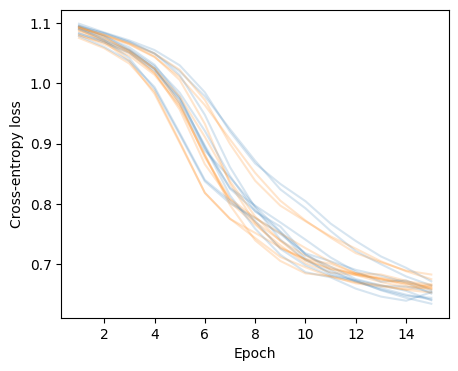

------------------------------ 
Training set:
Average log-likelihood = -4695.5 (60.3)
Average accuracy       = 71.8% (0.5%)
Average F1 score       = 71.0% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -664.8 (8.3)
Average accuracy       = 72.0% (0.5%)
Average F1 score       = 70.8% (0.8%)
------------------------------ 
Test set:
Average log-likelihood = -1357.1 (18.6)
Average accuracy       = 71.4% (0.4%)
Average F1 score       = 70.6% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


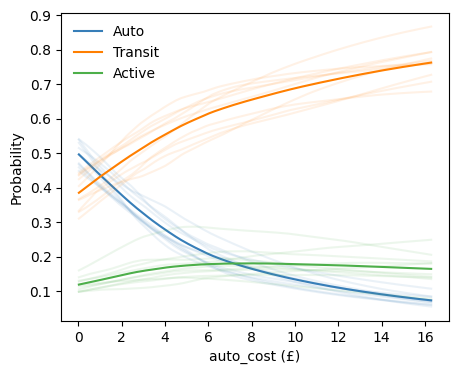

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4492.4 | acc = 72.9% | F1 = 72.8%
Validation set: LL = -643.8  | acc = 72.2% | F1 = 72.1%
Test set:       LL = -1296.8 | acc = 72.8% | F1 = 72.6%
Model 2 
Training set:   LL = -4469.6 | acc = 72.4% | F1 = 72.4%
Validation set: LL = -644.5  | acc = 72.2% | F1 = 72.1%
Test set:       LL = -1293.8 | acc = 72.5% | F1 = 72.4%
Model 3 
Training set:   LL = -4488.9 | acc = 72.3% | F1 = 72.3%
Validation set: LL = -654.3  | acc = 71.9% | F1 = 71.8%
Test set:       LL = -1314.5 | acc = 72.5% | F1 = 72.5%
Model 4 
Training set:   LL = -4526.2 | acc = 72.6% | F1 = 72.4%
Validation set: LL = -654.5  | acc = 71.3% | F1 = 71.1%
Test set:       LL = -1306.5 | acc = 72.9% | F1 = 72.7%
Model 5 
Training set:   LL = -4444.7 | acc = 73.0% | F1 = 72.9%
Validation set: LL = -647.0  | acc = 71.9% | F1 = 71.7%
Test set:       LL = -1296.5 | acc = 72.8% | F1 = 72.7%
Model 6 
Training set:   LL = -4489.8 | acc = 72.7% | F1 = 72.6%
Valid

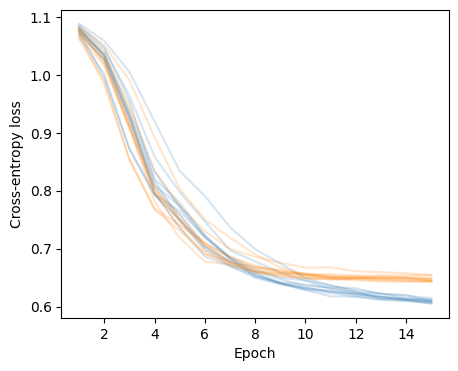

------------------------------ 
Training set:
Average log-likelihood = -4482.5 (25.9)
Average accuracy       = 72.7% (0.2%)
Average F1 score       = 72.6% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -647.3 (4.1)
Average accuracy       = 71.9% (0.3%)
Average F1 score       = 71.7% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1300.0 (6.6)
Average accuracy       = 72.7% (0.2%)
Average F1 score       = 72.5% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


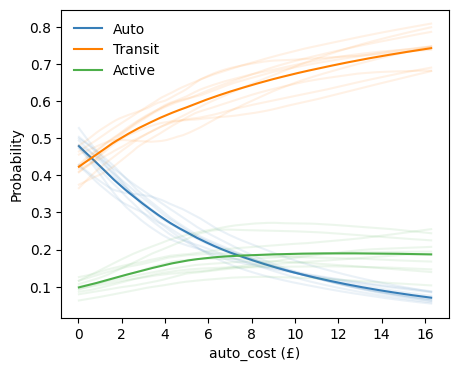

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4419.9 | acc = 72.8% | F1 = 72.8%
Validation set: LL = -640.8  | acc = 72.1% | F1 = 72.1%
Test set:       LL = -1288.0 | acc = 73.0% | F1 = 73.0%
Model 2 
Training set:   LL = -4365.3 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -634.7  | acc = 72.8% | F1 = 72.7%
Test set:       LL = -1278.3 | acc = 73.0% | F1 = 72.9%
Model 3 
Training set:   LL = -4441.2 | acc = 72.9% | F1 = 72.7%
Validation set: LL = -653.4  | acc = 72.5% | F1 = 72.2%
Test set:       LL = -1306.7 | acc = 72.6% | F1 = 72.3%
Model 4 
Training set:   LL = -4401.1 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -643.2  | acc = 72.3% | F1 = 72.2%
Test set:       LL = -1279.3 | acc = 73.3% | F1 = 73.2%
Model 5 
Training set:   LL = -4378.6 | acc = 73.1% | F1 = 73.0%
Validation set: LL = -643.2  | acc = 71.9% | F1 = 71.8%
Test set:       LL = -1281.2 | acc = 73.6% | F1 = 73.4%
Model 6 
Training set:   LL = -4474.8 | acc = 72.1% | F1 = 72.2%
Vali

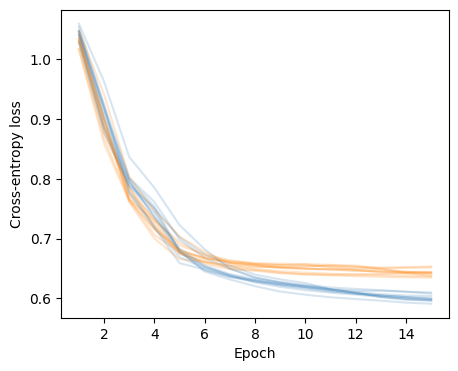

------------------------------ 
Training set:
Average log-likelihood = -4416.1 (39.1)
Average accuracy       = 72.9% (0.4%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -642.8 (5.7)
Average accuracy       = 72.2% (0.3%)
Average F1 score       = 72.1% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1288.6 (9.7)
Average accuracy       = 72.9% (0.4%)
Average F1 score       = 72.8% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.993 (0.004)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.994 (0.004)
Weak regularity   = 0.999 (0.001)
------------------------------


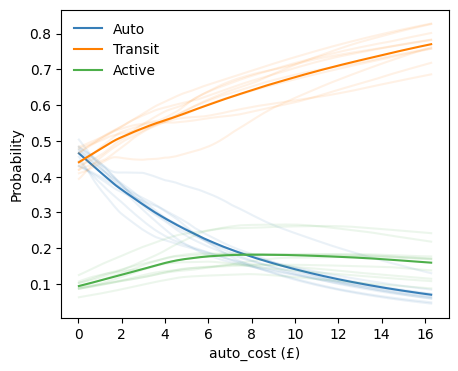

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4431.3 | acc = 72.9% | F1 = 72.9%
Validation set: LL = -641.3  | acc = 72.4% | F1 = 72.3%
Test set:       LL = -1292.8 | acc = 72.7% | F1 = 72.5%
Model 2 
Training set:   LL = -4359.1 | acc = 73.4% | F1 = 73.3%
Validation set: LL = -634.5  | acc = 72.8% | F1 = 72.7%
Test set:       LL = -1276.6 | acc = 73.2% | F1 = 73.0%
Model 3 
Training set:   LL = -4365.6 | acc = 73.1% | F1 = 73.0%
Validation set: LL = -643.3  | acc = 72.2% | F1 = 72.0%
Test set:       LL = -1295.2 | acc = 72.9% | F1 = 72.7%
Model 4 
Training set:   LL = -4439.0 | acc = 72.8% | F1 = 72.8%
Validation set: LL = -649.0  | acc = 71.6% | F1 = 71.6%
Test set:       LL = -1290.9 | acc = 72.8% | F1 = 72.7%
Model 5 
Training set:   LL = -4387.0 | acc = 73.2% | F1 = 73.2%
Validation set: LL = -644.6  | acc = 72.0% | F1 = 71.9%
Test set:       LL = -1283.4 | acc = 73.2% | F1 = 73.0%
Model 6 
Training set:   LL = -4457.3 | acc = 72.4% | F1 = 72.5%
Val

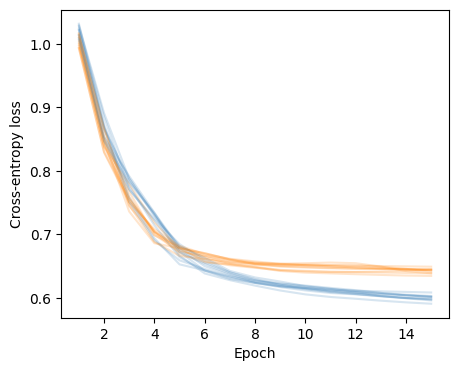

------------------------------ 
Training set:
Average log-likelihood = -4403.7 (31.3)
Average accuracy       = 73.1% (0.3%)
Average F1 score       = 73.0% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -642.3 (4.0)
Average accuracy       = 72.1% (0.4%)
Average F1 score       = 72.0% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1287.8 (6.3)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.978 (0.011)
Weak regularity   = 0.992 (0.006)
------------------------------ 
Validation set:
Strong regularity = 0.975 (0.015)
Weak regularity   = 0.990 (0.010)
------------------------------ 
Test set:
Strong regularity = 0.980 (0.013)
Weak regularity   = 0.992 (0.007)
------------------------------


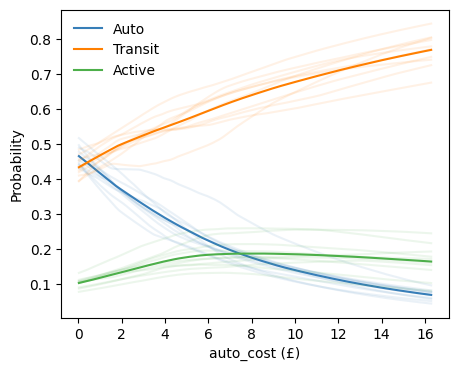

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4420.0 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -642.0  | acc = 72.4% | F1 = 72.2%
Test set:       LL = -1291.3 | acc = 72.8% | F1 = 72.7%
Model 2 
Training set:   LL = -4409.1 | acc = 73.3% | F1 = 73.2%
Validation set: LL = -639.8  | acc = 72.3% | F1 = 72.3%
Test set:       LL = -1284.4 | acc = 73.0% | F1 = 72.9%
Model 3 
Training set:   LL = -4404.0 | acc = 72.8% | F1 = 72.7%
Validation set: LL = -647.3  | acc = 71.9% | F1 = 71.8%
Test set:       LL = -1301.9 | acc = 72.4% | F1 = 72.3%
Model 4 
Training set:   LL = -4433.7 | acc = 72.5% | F1 = 72.5%
Validation set: LL = -648.8  | acc = 72.0% | F1 = 72.0%
Test set:       LL = -1290.2 | acc = 72.8% | F1 = 72.7%
Model 5 
Training set:   LL = -4411.9 | acc = 73.4% | F1 = 73.3%
Validation set: LL = -647.0  | acc = 72.1% | F1 = 71.9%
Test set:       LL = -1286.8 | acc = 73.2% | F1 = 73.0%
Model 6 
Training set:   LL = -4411.1 | acc = 73.3% | F1 = 73.3%
Va

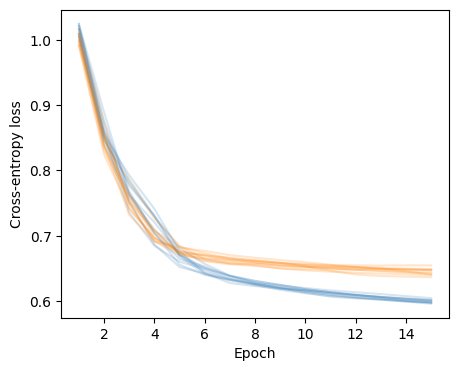

------------------------------ 
Training set:
Average log-likelihood = -4423.3 (27.2)
Average accuracy       = 73.0% (0.4%)
Average F1 score       = 73.0% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -644.8 (5.0)
Average accuracy       = 72.2% (0.3%)
Average F1 score       = 72.1% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1291.7 (7.3)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 72.6% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.948 (0.030)
Weak regularity   = 0.969 (0.024)
------------------------------ 
Validation set:
Strong regularity = 0.947 (0.033)
Weak regularity   = 0.969 (0.027)
------------------------------ 
Test set:
Strong regularity = 0.951 (0.033)
Weak regularity   = 0.970 (0.026)
------------------------------


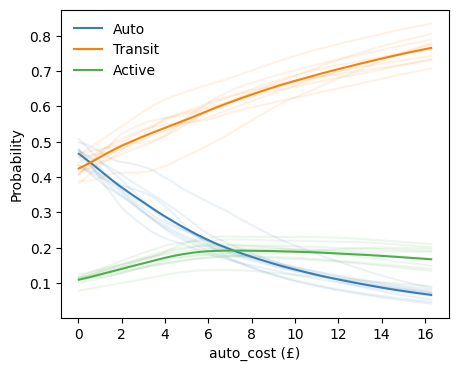

------------------------------ 
Model comparison:


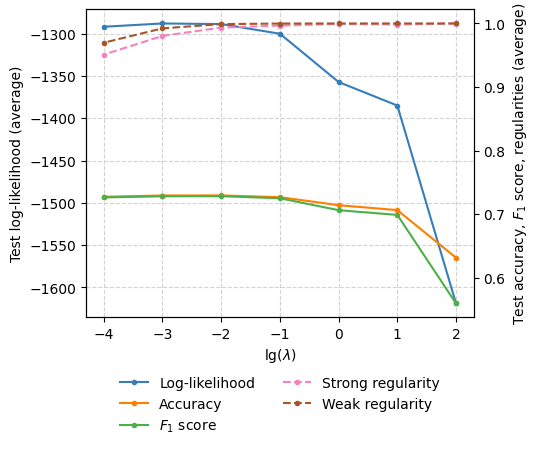

In [50]:
# With sum
result(DNN, 15, 'PGR', [10**i for i in range(2, -5, -1)])

### UGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5187.0 | acc = 68.6% | F1 = 66.5%
Validation set: LL = -729.7  | acc = 68.0% | F1 = 65.4%
Test set:       LL = -1487.3 | acc = 68.1% | F1 = 65.9%
Model 2 
Training set:   LL = -5071.5 | acc = 69.4% | F1 = 68.0%
Validation set: LL = -717.4  | acc = 69.2% | F1 = 67.6%
Test set:       LL = -1454.3 | acc = 69.0% | F1 = 67.7%
Model 3 
Training set:   LL = -5181.2 | acc = 69.7% | F1 = 68.2%
Validation set: LL = -736.1  | acc = 69.4% | F1 = 67.6%
Test set:       LL = -1489.5 | acc = 68.8% | F1 = 67.4%
Model 4 
Training set:   LL = -5247.1 | acc = 67.9% | F1 = 65.5%
Validation set: LL = -738.8  | acc = 67.8% | F1 = 64.6%
Test set:       LL = -1498.3 | acc = 67.3% | F1 = 64.8%
Model 5 
Training set:   LL = -5619.6 | acc = 64.9% | F1 = 58.3%
Validation set: LL = -786.1  | acc = 66.2% | F1 = 59.7%
Test set:       LL = -1614.1 | acc = 64.5% | F1 = 57.9%
Model 6 
Training set:   LL = -5124.9 | acc = 68.3% | F1 = 66.1%
Valid

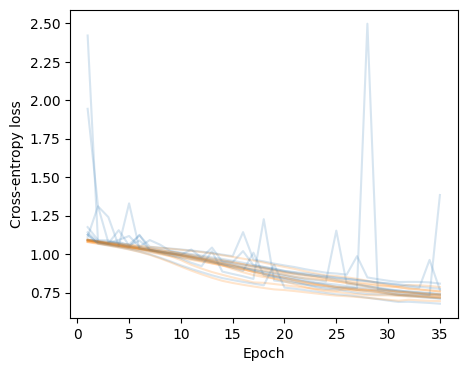

------------------------------ 
Training set:
Average log-likelihood = -5215.1 (201.5)
Average accuracy       = 68.1% (1.9%)
Average F1 score       = 65.1% (3.8%)
------------------------------ 
Validation set:
Average log-likelihood = -735.3 (24.9)
Average accuracy       = 68.1% (1.3%)
Average F1 score       = 64.7% (3.0%)
------------------------------ 
Test set:
Average log-likelihood = -1496.9 (56.0)
Average accuracy       = 67.6% (1.9%)
Average F1 score       = 64.5% (3.9%)
------------------------------ 
Training set:
Strong regularity = 0.977 (0.039)
Weak regularity   = 0.993 (0.014)
------------------------------ 
Validation set:
Strong regularity = 0.979 (0.036)
Weak regularity   = 0.993 (0.013)
------------------------------ 
Test set:
Strong regularity = 0.976 (0.042)
Weak regularity   = 0.992 (0.015)
------------------------------


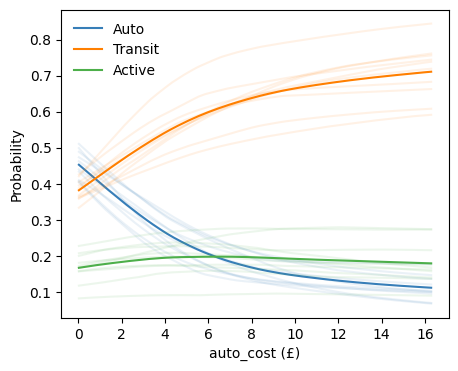

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4715.6 | acc = 71.9% | F1 = 71.2%
Validation set: LL = -671.6  | acc = 71.0% | F1 = 70.1%
Test set:       LL = -1362.3 | acc = 71.5% | F1 = 70.9%
Model 2 
Training set:   LL = -4617.7 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -663.6  | acc = 72.0% | F1 = 71.3%
Test set:       LL = -1332.1 | acc = 72.2% | F1 = 71.7%
Model 3 
Training set:   LL = -4696.0 | acc = 72.1% | F1 = 71.6%
Validation set: LL = -676.5  | acc = 71.8% | F1 = 71.1%
Test set:       LL = -1360.4 | acc = 71.3% | F1 = 70.8%
Model 4 
Training set:   LL = -4596.7 | acc = 72.5% | F1 = 72.1%
Validation set: LL = -659.8  | acc = 72.3% | F1 = 71.6%
Test set:       LL = -1339.0 | acc = 72.2% | F1 = 71.8%
Model 5 
Training set:   LL = -4649.7 | acc = 72.2% | F1 = 71.7%
Validation set: LL = -666.7  | acc = 71.7% | F1 = 71.0%
Test set:       LL = -1341.8 | acc = 72.0% | F1 = 71.5%
Model 6 
Training set:   LL = -4639.3 | acc = 72.4% | F1 = 71.9%
Valida

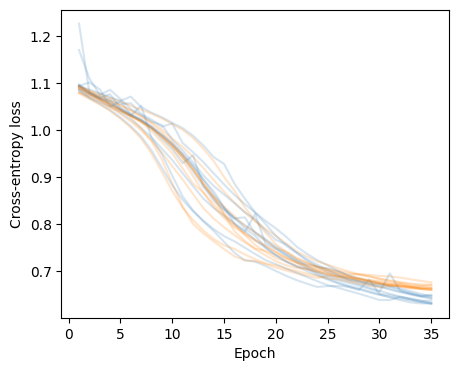

------------------------------ 
Training set:
Average log-likelihood = -4656.3 (38.4)
Average accuracy       = 72.2% (0.2%)
Average F1 score       = 71.7% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -665.8 (5.3)
Average accuracy       = 71.8% (0.4%)
Average F1 score       = 71.0% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1346.5 (10.7)
Average accuracy       = 71.8% (0.4%)
Average F1 score       = 71.3% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 0.999 (0.001)
------------------------------


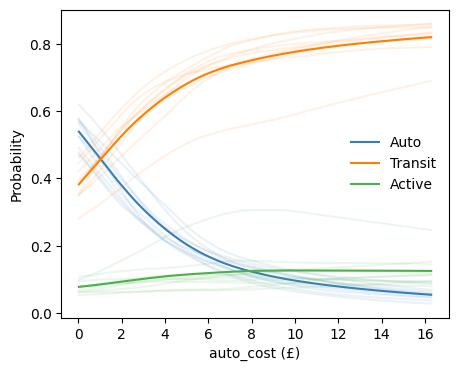

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4865.0 | acc = 70.3% | F1 = 69.2%
Validation set: LL = -686.5  | acc = 71.0% | F1 = 69.5%
Test set:       LL = -1400.0 | acc = 70.2% | F1 = 69.1%
Model 2 
Training set:   LL = -4868.8 | acc = 70.8% | F1 = 70.0%
Validation set: LL = -689.4  | acc = 69.8% | F1 = 68.4%
Test set:       LL = -1393.1 | acc = 70.4% | F1 = 69.6%
Model 3 
Training set:   LL = -4983.7 | acc = 70.2% | F1 = 69.2%
Validation set: LL = -707.0  | acc = 70.3% | F1 = 68.8%
Test set:       LL = -1431.6 | acc = 69.9% | F1 = 68.9%
Model 4 
Training set:   LL = -4802.6 | acc = 71.2% | F1 = 70.4%
Validation set: LL = -685.1  | acc = 70.7% | F1 = 69.5%
Test set:       LL = -1387.4 | acc = 70.7% | F1 = 69.9%
Model 5 
Training set:   LL = -4847.3 | acc = 70.5% | F1 = 69.3%
Validation set: LL = -689.6  | acc = 70.1% | F1 = 68.4%
Test set:       LL = -1400.9 | acc = 69.8% | F1 = 68.8%
Model 6 
Training set:   LL = -4928.2 | acc = 69.5% | F1 = 67.5%
Validat

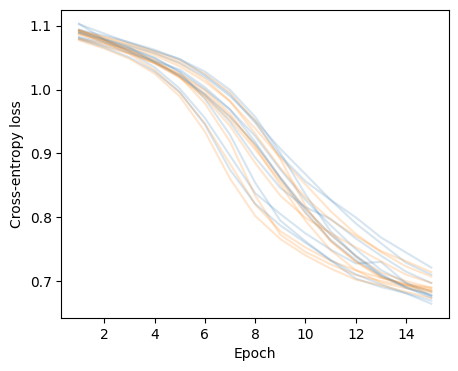

------------------------------ 
Training set:
Average log-likelihood = -4880.0 (91.0)
Average accuracy       = 70.5% (0.8%)
Average F1 score       = 69.4% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -690.7 (11.5)
Average accuracy       = 70.6% (0.8%)
Average F1 score       = 69.0% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1404.1 (25.4)
Average accuracy       = 70.1% (0.8%)
Average F1 score       = 69.0% (1.3%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 1.000 (0.000)
------------------------------


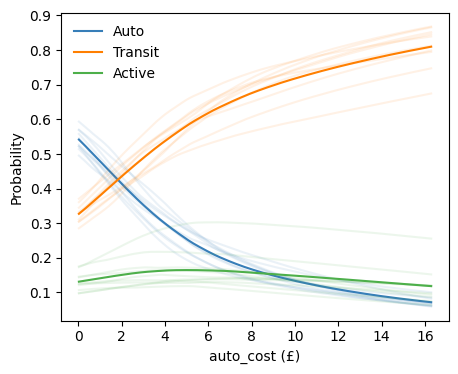

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4505.2 | acc = 73.2% | F1 = 72.9%
Validation set: LL = -644.3  | acc = 72.2% | F1 = 71.6%
Test set:       LL = -1300.3 | acc = 72.7% | F1 = 72.3%
Model 2 
Training set:   LL = -4498.7 | acc = 72.9% | F1 = 72.7%
Validation set: LL = -644.5  | acc = 72.2% | F1 = 72.0%
Test set:       LL = -1293.9 | acc = 72.7% | F1 = 72.4%
Model 3 
Training set:   LL = -4532.3 | acc = 72.3% | F1 = 72.2%
Validation set: LL = -658.0  | acc = 71.2% | F1 = 71.0%
Test set:       LL = -1314.6 | acc = 72.7% | F1 = 72.4%
Model 4 
Training set:   LL = -4504.9 | acc = 72.8% | F1 = 72.6%
Validation set: LL = -649.8  | acc = 72.2% | F1 = 71.7%
Test set:       LL = -1305.2 | acc = 72.9% | F1 = 72.5%
Model 5 
Training set:   LL = -4518.9 | acc = 72.8% | F1 = 72.4%
Validation set: LL = -652.0  | acc = 72.7% | F1 = 72.0%
Test set:       LL = -1301.3 | acc = 72.3% | F1 = 71.8%
Model 6 
Training set:   LL = -4481.8 | acc = 73.2% | F1 = 73.0%
Valid

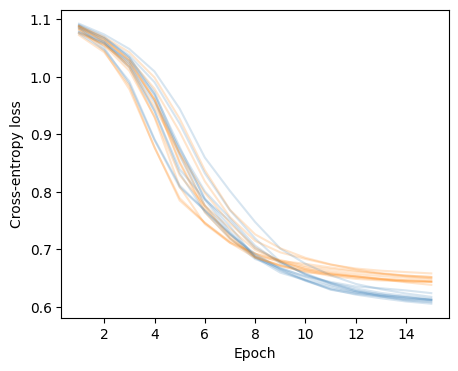

------------------------------ 
Training set:
Average log-likelihood = -4506.6 (17.9)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 72.6% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -647.3 (5.5)
Average accuracy       = 72.3% (0.4%)
Average F1 score       = 71.9% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1301.2 (6.2)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 72.3% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.011)
Weak regularity   = 0.998 (0.006)
------------------------------ 
Validation set:
Strong regularity = 0.995 (0.011)
Weak regularity   = 0.998 (0.006)
------------------------------ 
Test set:
Strong regularity = 0.995 (0.011)
Weak regularity   = 0.998 (0.006)
------------------------------


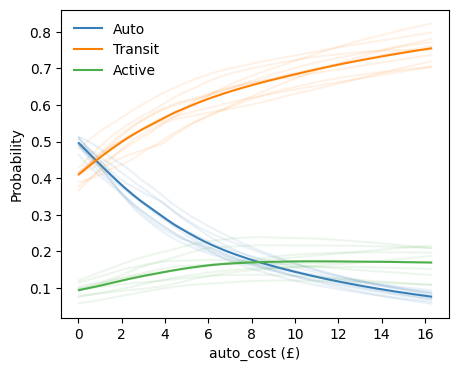

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4416.1 | acc = 73.9% | F1 = 73.7%
Validation set: LL = -640.7  | acc = 72.8% | F1 = 72.4%
Test set:       LL = -1285.6 | acc = 73.0% | F1 = 72.7%
Model 2 
Training set:   LL = -4446.3 | acc = 72.7% | F1 = 72.8%
Validation set: LL = -644.5  | acc = 72.4% | F1 = 72.4%
Test set:       LL = -1290.6 | acc = 72.2% | F1 = 72.2%
Model 3 
Training set:   LL = -4406.7 | acc = 73.3% | F1 = 73.1%
Validation set: LL = -646.0  | acc = 72.4% | F1 = 72.0%
Test set:       LL = -1294.5 | acc = 73.0% | F1 = 72.8%
Model 4 
Training set:   LL = -4456.5 | acc = 72.5% | F1 = 72.5%
Validation set: LL = -648.8  | acc = 72.3% | F1 = 72.2%
Test set:       LL = -1290.1 | acc = 72.7% | F1 = 72.6%
Model 5 
Training set:   LL = -4476.5 | acc = 72.7% | F1 = 72.6%
Validation set: LL = -653.2  | acc = 72.2% | F1 = 72.1%
Test set:       LL = -1293.5 | acc = 72.3% | F1 = 72.2%
Model 6 
Training set:   LL = -4415.2 | acc = 73.2% | F1 = 73.1%
Vali

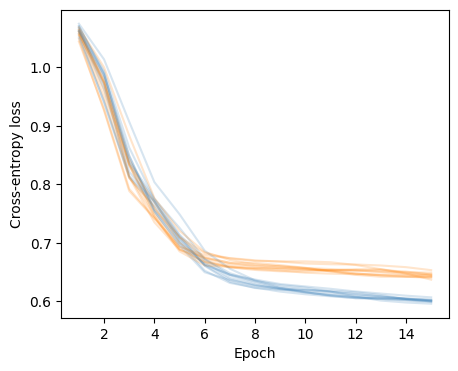

------------------------------ 
Training set:
Average log-likelihood = -4434.8 (24.4)
Average accuracy       = 73.1% (0.5%)
Average F1 score       = 73.0% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -644.2 (4.3)
Average accuracy       = 72.5% (0.2%)
Average F1 score       = 72.2% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1288.6 (3.8)
Average accuracy       = 72.7% (0.2%)
Average F1 score       = 72.5% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.994 (0.009)
Weak regularity   = 0.998 (0.005)
------------------------------ 
Validation set:
Strong regularity = 0.991 (0.012)
Weak regularity   = 0.997 (0.007)
------------------------------ 
Test set:
Strong regularity = 0.994 (0.009)
Weak regularity   = 0.998 (0.004)
------------------------------


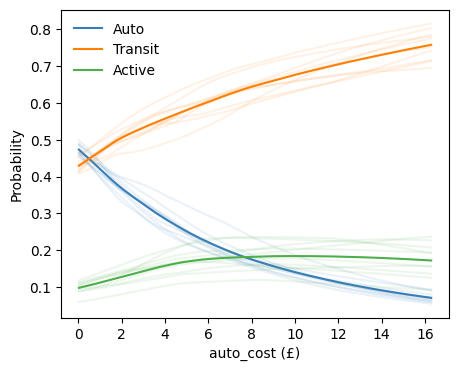

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4404.0 | acc = 73.7% | F1 = 73.5%
Validation set: LL = -640.6  | acc = 72.7% | F1 = 72.3%
Test set:       LL = -1285.0 | acc = 73.0% | F1 = 72.8%
Model 2 
Training set:   LL = -4409.2 | acc = 72.9% | F1 = 72.9%
Validation set: LL = -640.5  | acc = 72.7% | F1 = 72.7%
Test set:       LL = -1285.5 | acc = 73.0% | F1 = 72.9%
Model 3 
Training set:   LL = -4396.1 | acc = 72.9% | F1 = 72.9%
Validation set: LL = -647.7  | acc = 72.0% | F1 = 71.8%
Test set:       LL = -1297.9 | acc = 72.4% | F1 = 72.3%
Model 4 
Training set:   LL = -4445.2 | acc = 72.7% | F1 = 72.7%
Validation set: LL = -648.7  | acc = 72.8% | F1 = 72.8%
Test set:       LL = -1288.5 | acc = 72.8% | F1 = 72.7%
Model 5 
Training set:   LL = -4440.5 | acc = 72.7% | F1 = 72.7%
Validation set: LL = -651.8  | acc = 72.2% | F1 = 72.1%
Test set:       LL = -1292.5 | acc = 72.2% | F1 = 72.2%
Model 6 
Training set:   LL = -4447.1 | acc = 72.8% | F1 = 72.9%
Val

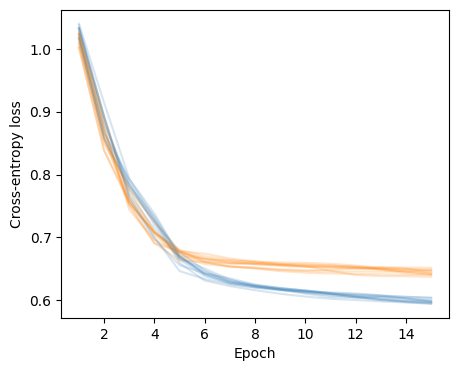

------------------------------ 
Training set:
Average log-likelihood = -4421.6 (23.7)
Average accuracy       = 73.1% (0.4%)
Average F1 score       = 73.0% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -644.4 (4.2)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 72.4% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1289.3 (3.7)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 72.6% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.988 (0.015)
Weak regularity   = 0.995 (0.011)
------------------------------ 
Validation set:
Strong regularity = 0.988 (0.019)
Weak regularity   = 0.995 (0.014)
------------------------------ 
Test set:
Strong regularity = 0.989 (0.016)
Weak regularity   = 0.996 (0.011)
------------------------------


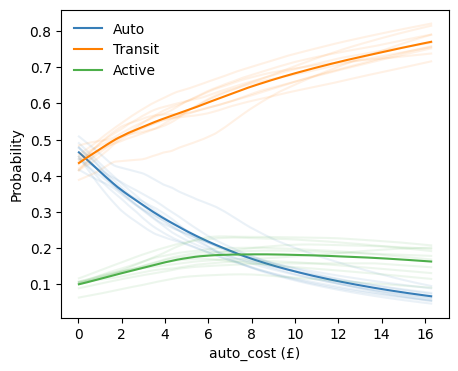

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4410.3 | acc = 73.5% | F1 = 73.3%
Validation set: LL = -640.0  | acc = 72.7% | F1 = 72.4%
Test set:       LL = -1288.2 | acc = 72.9% | F1 = 72.7%
Model 2 
Training set:   LL = -4419.2 | acc = 73.0% | F1 = 73.0%
Validation set: LL = -641.5  | acc = 72.5% | F1 = 72.5%
Test set:       LL = -1287.9 | acc = 73.0% | F1 = 72.9%
Model 3 
Training set:   LL = -4390.9 | acc = 72.9% | F1 = 72.8%
Validation set: LL = -646.1  | acc = 72.0% | F1 = 71.8%
Test set:       LL = -1299.5 | acc = 72.5% | F1 = 72.4%
Model 4 
Training set:   LL = -4435.8 | acc = 72.7% | F1 = 72.7%
Validation set: LL = -648.6  | acc = 72.2% | F1 = 72.2%
Test set:       LL = -1290.0 | acc = 72.9% | F1 = 72.8%
Model 5 
Training set:   LL = -4416.8 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -646.8  | acc = 72.5% | F1 = 72.3%
Test set:       LL = -1287.4 | acc = 73.0% | F1 = 72.8%
Model 6 
Training set:   LL = -4478.1 | acc = 72.3% | F1 = 72.5%
Va

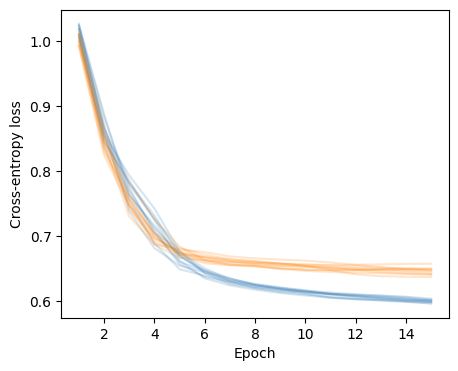

------------------------------ 
Training set:
Average log-likelihood = -4432.4 (36.8)
Average accuracy       = 73.0% (0.5%)
Average F1 score       = 72.9% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -645.9 (5.6)
Average accuracy       = 72.2% (0.4%)
Average F1 score       = 72.0% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1293.3 (7.4)
Average accuracy       = 72.6% (0.3%)
Average F1 score       = 72.5% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.975 (0.020)
Weak regularity   = 0.988 (0.016)
------------------------------ 
Validation set:
Strong regularity = 0.973 (0.024)
Weak regularity   = 0.988 (0.020)
------------------------------ 
Test set:
Strong regularity = 0.975 (0.024)
Weak regularity   = 0.988 (0.019)
------------------------------


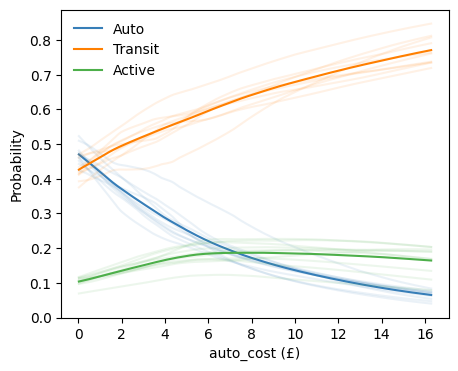

------------------------------ 
Model comparison:


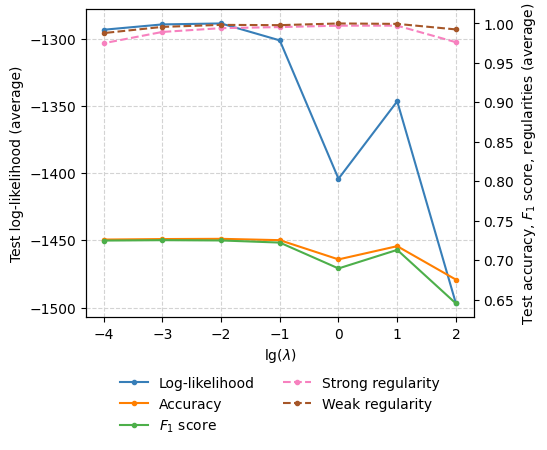

In [51]:
# With sum
result(DNN, 15, 'UGR', [10**i for i in range(2, -5, -1)])

### LGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5854.4 | acc = 63.6% | F1 = 56.4%
Validation set: LL = -822.5  | acc = 63.6% | F1 = 56.6%
Test set:       LL = -1702.5 | acc = 62.6% | F1 = 55.2%
Model 2 
Training set:   LL = -6249.4 | acc = 63.3% | F1 = 55.9%
Validation set: LL = -879.1  | acc = 65.3% | F1 = 57.9%
Test set:       LL = -1796.9 | acc = 62.4% | F1 = 54.6%
Model 3 
Training set:   LL = -6355.9 | acc = 61.2% | F1 = 53.6%
Validation set: LL = -894.8  | acc = 62.4% | F1 = 54.9%
Test set:       LL = -1822.8 | acc = 60.5% | F1 = 52.6%
Model 4 
Training set:   LL = -5719.6 | acc = 63.8% | F1 = 56.2%
Validation set: LL = -801.8  | acc = 65.5% | F1 = 57.9%
Test set:       LL = -1642.1 | acc = 63.4% | F1 = 55.3%
Model 5 
Training set:   LL = -6409.0 | acc = 62.0% | F1 = 54.5%
Validation set: LL = -905.9  | acc = 63.1% | F1 = 55.6%
Test set:       LL = -1838.4 | acc = 61.1% | F1 = 53.2%
Model 6 
Training set:   LL = -5413.5 | acc = 65.4% | F1 = 58.8%
Valid

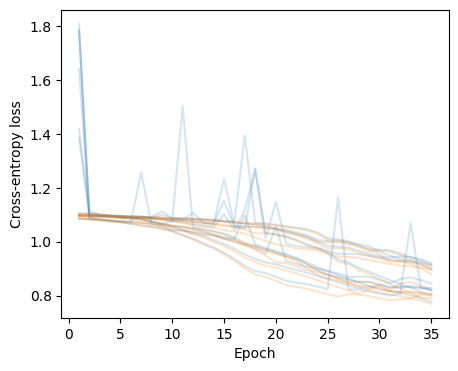

------------------------------ 
Training set:
Average log-likelihood = -5953.6 (351.5)
Average accuracy       = 62.8% (1.8%)
Average F1 score       = 55.5% (1.9%)
------------------------------ 
Validation set:
Average log-likelihood = -836.7 (49.5)
Average accuracy       = 64.1% (1.9%)
Average F1 score       = 56.9% (1.8%)
------------------------------ 
Test set:
Average log-likelihood = -1711.0 (98.1)
Average accuracy       = 62.0% (1.7%)
Average F1 score       = 54.3% (1.8%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


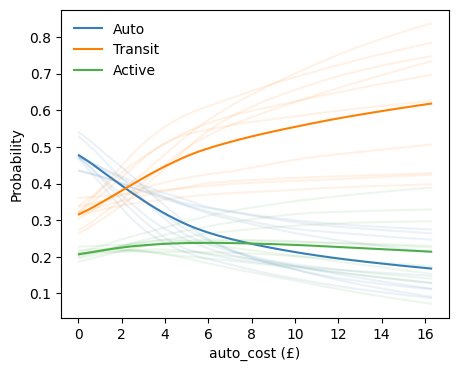

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4915.2 | acc = 69.8% | F1 = 68.5%
Validation set: LL = -690.9  | acc = 70.1% | F1 = 68.2%
Test set:       LL = -1425.0 | acc = 68.8% | F1 = 67.4%
Model 2 
Training set:   LL = -5030.2 | acc = 67.4% | F1 = 63.4%
Validation set: LL = -705.7  | acc = 67.6% | F1 = 62.8%
Test set:       LL = -1463.3 | acc = 67.0% | F1 = 62.8%
Model 3 
Training set:   LL = -5009.0 | acc = 69.4% | F1 = 67.7%
Validation set: LL = -710.2  | acc = 70.0% | F1 = 67.4%
Test set:       LL = -1453.8 | acc = 68.7% | F1 = 66.8%
Model 4 
Training set:   LL = -5193.3 | acc = 67.1% | F1 = 63.2%
Validation set: LL = -732.1  | acc = 67.3% | F1 = 63.4%
Test set:       LL = -1496.4 | acc = 66.4% | F1 = 62.6%
Model 5 
Training set:   LL = -4813.4 | acc = 70.5% | F1 = 69.5%
Validation set: LL = -687.5  | acc = 69.9% | F1 = 68.3%
Test set:       LL = -1400.2 | acc = 70.2% | F1 = 69.2%
Model 6 
Training set:   LL = -6838.5 | acc = 61.9% | F1 = 55.1%
Valida

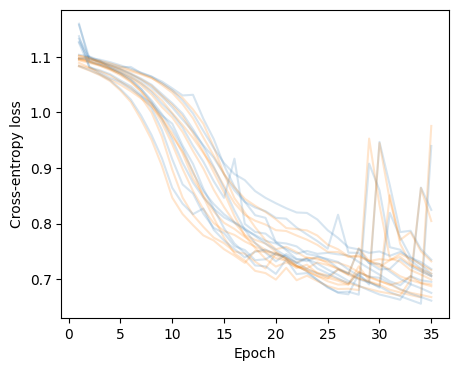

------------------------------ 
Training set:
Average log-likelihood = -5228.7 (599.6)
Average accuracy       = 68.0% (2.8%)
Average F1 score       = 64.9% (5.0%)
------------------------------ 
Validation set:
Average log-likelihood = -739.1 (86.2)
Average accuracy       = 68.2% (2.8%)
Average F1 score       = 64.6% (4.6%)
------------------------------ 
Test set:
Average log-likelihood = -1522.5 (190.5)
Average accuracy       = 67.1% (3.3%)
Average F1 score       = 63.9% (5.4%)
------------------------------ 
Training set:
Strong regularity = 0.995 (0.014)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.993 (0.018)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.994 (0.016)
Weak regularity   = 1.000 (0.000)
------------------------------


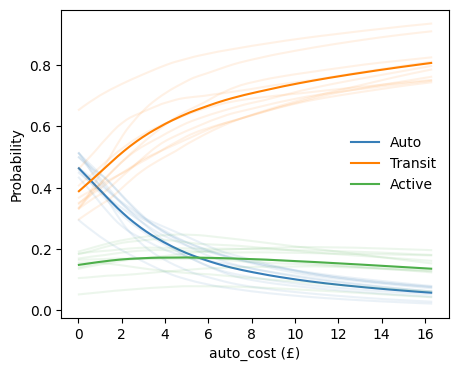

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5151.7 | acc = 66.7% | F1 = 61.5%
Validation set: LL = -727.2  | acc = 67.4% | F1 = 62.0%
Test set:       LL = -1505.7 | acc = 65.8% | F1 = 60.6%
Model 2 
Training set:   LL = -4742.6 | acc = 71.1% | F1 = 70.2%
Validation set: LL = -667.2  | acc = 71.7% | F1 = 70.6%
Test set:       LL = -1363.3 | acc = 70.8% | F1 = 70.0%
Model 3 
Training set:   LL = -4919.8 | acc = 70.1% | F1 = 68.6%
Validation set: LL = -700.5  | acc = 70.0% | F1 = 67.8%
Test set:       LL = -1427.5 | acc = 69.5% | F1 = 67.9%
Model 4 
Training set:   LL = -4926.0 | acc = 68.7% | F1 = 65.7%
Validation set: LL = -702.1  | acc = 68.9% | F1 = 65.4%
Test set:       LL = -1443.5 | acc = 67.8% | F1 = 65.0%
Model 5 
Training set:   LL = -4829.6 | acc = 71.0% | F1 = 70.3%
Validation set: LL = -688.7  | acc = 70.9% | F1 = 69.9%
Test set:       LL = -1397.2 | acc = 71.1% | F1 = 70.5%
Model 6 
Training set:   LL = -4816.8 | acc = 71.1% | F1 = 70.6%
Validat

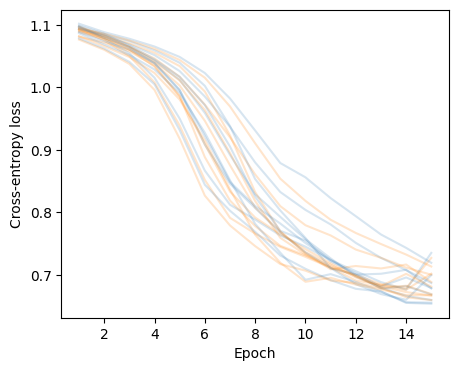

------------------------------ 
Training set:
Average log-likelihood = -4869.7 (139.9)
Average accuracy       = 70.1% (1.6%)
Average F1 score       = 68.5% (2.9%)
------------------------------ 
Validation set:
Average log-likelihood = -687.7 (21.4)
Average accuracy       = 70.5% (1.5%)
Average F1 score       = 68.6% (3.0%)
------------------------------ 
Test set:
Average log-likelihood = -1408.9 (45.5)
Average accuracy       = 69.7% (1.8%)
Average F1 score       = 68.1% (3.2%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------


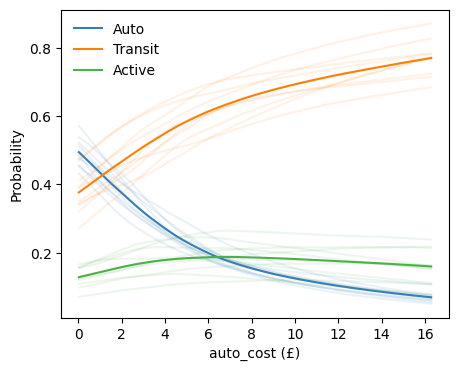

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4491.5 | acc = 73.4% | F1 = 73.1%
Validation set: LL = -640.7  | acc = 72.5% | F1 = 71.9%
Test set:       LL = -1300.1 | acc = 72.2% | F1 = 71.9%
Model 2 
Training set:   LL = -4502.2 | acc = 72.3% | F1 = 72.2%
Validation set: LL = -645.1  | acc = 71.9% | F1 = 71.8%
Test set:       LL = -1299.3 | acc = 72.2% | F1 = 72.1%
Model 3 
Training set:   LL = -4512.8 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -655.0  | acc = 71.5% | F1 = 71.0%
Test set:       LL = -1316.6 | acc = 72.6% | F1 = 72.3%
Model 4 
Training set:   LL = -4481.2 | acc = 73.4% | F1 = 73.1%
Validation set: LL = -647.3  | acc = 72.8% | F1 = 72.3%
Test set:       LL = -1298.7 | acc = 72.8% | F1 = 72.5%
Model 5 
Training set:   LL = -4497.6 | acc = 72.8% | F1 = 72.3%
Validation set: LL = -650.4  | acc = 72.7% | F1 = 71.8%
Test set:       LL = -1307.4 | acc = 72.3% | F1 = 71.7%
Model 6 
Training set:   LL = -4505.3 | acc = 73.1% | F1 = 72.5%
Valid

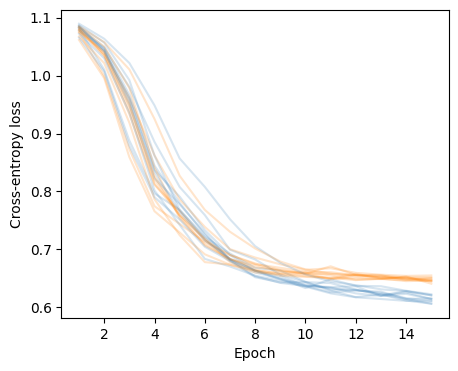

------------------------------ 
Training set:
Average log-likelihood = -4499.3 (16.0)
Average accuracy       = 72.9% (0.4%)
Average F1 score       = 72.6% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -647.8 (3.9)
Average accuracy       = 72.3% (0.5%)
Average F1 score       = 71.8% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1305.0 (7.3)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 72.1% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.004)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------


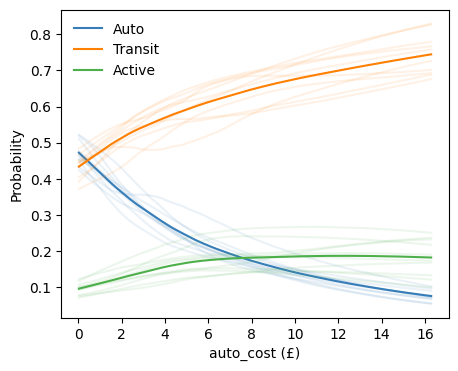

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4426.9 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -639.8  | acc = 72.0% | F1 = 71.9%
Test set:       LL = -1287.2 | acc = 73.1% | F1 = 72.9%
Model 2 
Training set:   LL = -4363.6 | acc = 73.3% | F1 = 73.3%
Validation set: LL = -634.5  | acc = 72.8% | F1 = 72.7%
Test set:       LL = -1278.8 | acc = 73.0% | F1 = 72.9%
Model 3 
Training set:   LL = -4457.1 | acc = 72.7% | F1 = 72.5%
Validation set: LL = -653.1  | acc = 72.3% | F1 = 72.0%
Test set:       LL = -1309.1 | acc = 72.5% | F1 = 72.3%
Model 4 
Training set:   LL = -4390.9 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -641.3  | acc = 72.7% | F1 = 72.6%
Test set:       LL = -1275.8 | acc = 73.2% | F1 = 73.1%
Model 5 
Training set:   LL = -4372.4 | acc = 73.6% | F1 = 73.4%
Validation set: LL = -643.5  | acc = 71.6% | F1 = 71.5%
Test set:       LL = -1282.3 | acc = 73.3% | F1 = 73.2%
Model 6 
Training set:   LL = -4501.7 | acc = 71.8% | F1 = 71.9%
Vali

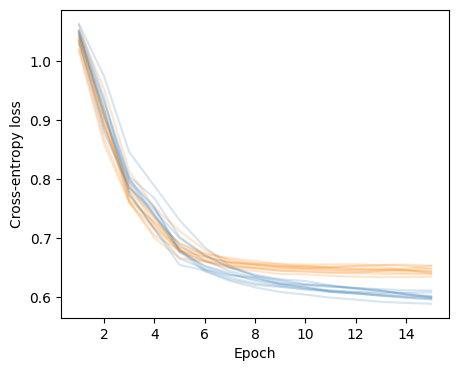

------------------------------ 
Training set:
Average log-likelihood = -4429.8 (45.5)
Average accuracy       = 72.9% (0.5%)
Average F1 score       = 72.8% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -644.4 (5.9)
Average accuracy       = 72.0% (0.5%)
Average F1 score       = 71.9% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1291.1 (11.6)
Average accuracy       = 72.8% (0.4%)
Average F1 score       = 72.7% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.992 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.991 (0.008)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.993 (0.006)
Weak regularity   = 0.998 (0.002)
------------------------------


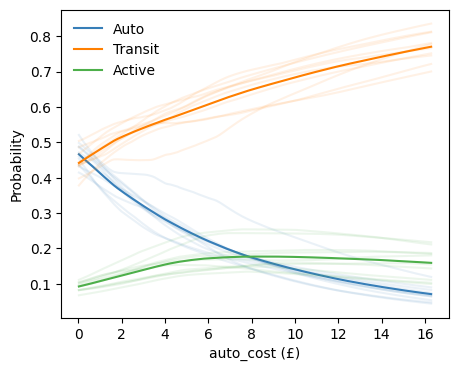

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4422.3 | acc = 73.5% | F1 = 73.3%
Validation set: LL = -639.0  | acc = 72.3% | F1 = 71.9%
Test set:       LL = -1290.7 | acc = 72.8% | F1 = 72.5%
Model 2 
Training set:   LL = -4359.6 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -633.4  | acc = 72.7% | F1 = 72.6%
Test set:       LL = -1277.3 | acc = 73.4% | F1 = 73.2%
Model 3 
Training set:   LL = -4366.4 | acc = 73.1% | F1 = 73.0%
Validation set: LL = -643.1  | acc = 72.3% | F1 = 72.1%
Test set:       LL = -1294.2 | acc = 73.1% | F1 = 73.0%
Model 4 
Training set:   LL = -4440.9 | acc = 72.8% | F1 = 72.8%
Validation set: LL = -648.6  | acc = 71.8% | F1 = 71.8%
Test set:       LL = -1291.0 | acc = 72.7% | F1 = 72.6%
Model 5 
Training set:   LL = -4377.6 | acc = 73.4% | F1 = 73.3%
Validation set: LL = -644.2  | acc = 72.0% | F1 = 71.9%
Test set:       LL = -1282.2 | acc = 73.4% | F1 = 73.2%
Model 6 
Training set:   LL = -4411.7 | acc = 73.0% | F1 = 73.0%
Val

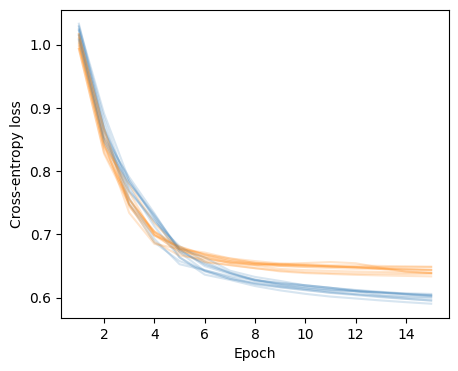

------------------------------ 
Training set:
Average log-likelihood = -4403.7 (30.2)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 73.1% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -641.6 (4.6)
Average accuracy       = 72.2% (0.4%)
Average F1 score       = 72.0% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1287.4 (6.8)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.978 (0.012)
Weak regularity   = 0.991 (0.008)
------------------------------ 
Validation set:
Strong regularity = 0.975 (0.017)
Weak regularity   = 0.990 (0.011)
------------------------------ 
Test set:
Strong regularity = 0.981 (0.014)
Weak regularity   = 0.992 (0.009)
------------------------------


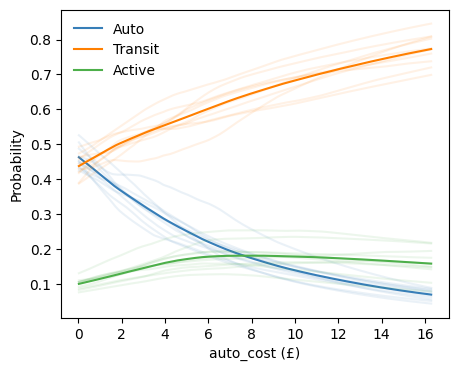

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4418.2 | acc = 73.2% | F1 = 73.1%
Validation set: LL = -641.2  | acc = 72.3% | F1 = 72.1%
Test set:       LL = -1290.1 | acc = 72.9% | F1 = 72.7%
Model 2 
Training set:   LL = -4403.9 | acc = 73.3% | F1 = 73.3%
Validation set: LL = -638.9  | acc = 72.3% | F1 = 72.2%
Test set:       LL = -1283.0 | acc = 72.9% | F1 = 72.8%
Model 3 
Training set:   LL = -4391.3 | acc = 72.9% | F1 = 72.8%
Validation set: LL = -645.9  | acc = 72.1% | F1 = 72.0%
Test set:       LL = -1299.1 | acc = 72.5% | F1 = 72.4%
Model 4 
Training set:   LL = -4435.1 | acc = 72.5% | F1 = 72.6%
Validation set: LL = -649.6  | acc = 72.2% | F1 = 72.2%
Test set:       LL = -1291.5 | acc = 72.4% | F1 = 72.4%
Model 5 
Training set:   LL = -4415.4 | acc = 73.4% | F1 = 73.3%
Validation set: LL = -647.3  | acc = 72.0% | F1 = 71.8%
Test set:       LL = -1287.1 | acc = 73.2% | F1 = 73.0%
Model 6 
Training set:   LL = -4424.0 | acc = 73.1% | F1 = 73.1%
Va

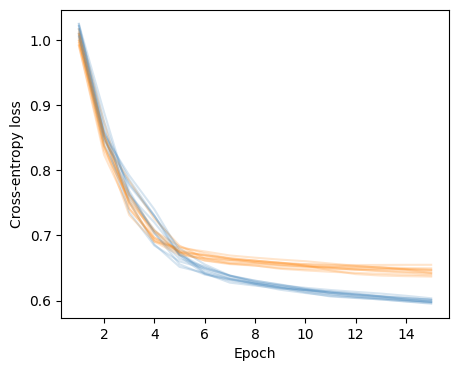

------------------------------ 
Training set:
Average log-likelihood = -4423.3 (29.2)
Average accuracy       = 73.1% (0.4%)
Average F1 score       = 73.0% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -644.8 (5.1)
Average accuracy       = 72.3% (0.3%)
Average F1 score       = 72.2% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1291.6 (7.3)
Average accuracy       = 72.7% (0.2%)
Average F1 score       = 72.6% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.031)
Weak regularity   = 0.968 (0.024)
------------------------------ 
Validation set:
Strong regularity = 0.947 (0.033)
Weak regularity   = 0.968 (0.027)
------------------------------ 
Test set:
Strong regularity = 0.950 (0.033)
Weak regularity   = 0.969 (0.026)
------------------------------


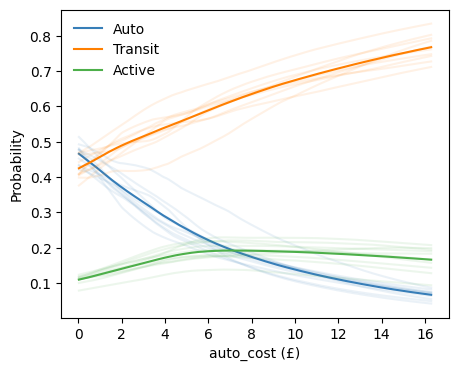

------------------------------ 
Model comparison:


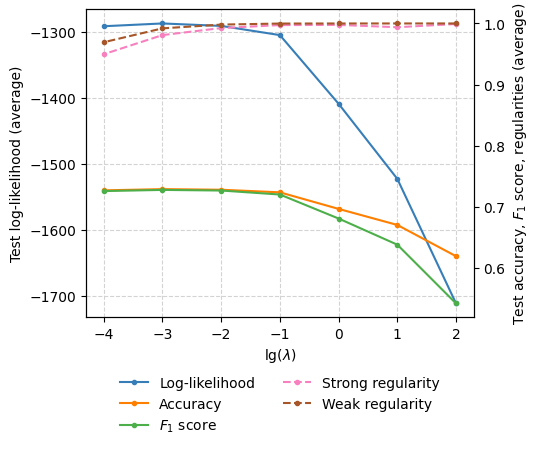

In [52]:
# With sum
result(DNN, 15, 'LGR', [10**i for i in range(2, -5, -1)])

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [53]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(7, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :7])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 7:9], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 9:11], dim=1)
        V3 = betas[:, 6] * x[:, 11]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4484.6 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -638.9  | acc = 73.1% | F1 = 72.5%
Test set:       LL = -1303.8 | acc = 73.0% | F1 = 72.6%
Model 2 
Training set:   LL = -4508.3 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.5  | acc = 73.2% | F1 = 72.7%
Test set:       LL = -1309.8 | acc = 73.2% | F1 = 72.7%
Model 3 
Training set:   LL = -4504.6 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -638.0  | acc = 73.0% | F1 = 72.4%
Test set:       LL = -1305.4 | acc = 73.2% | F1 = 72.7%
Model 4 
Training set:   LL = -4508.8 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.2  | acc = 73.3% | F1 = 72.7%
Test set:       LL = -1307.0 | acc = 72.8% | F1 = 72.4%
Model 5 
Training set:   LL = -4498.3 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -638.1  | acc = 72.3% | F1 = 71.8%
Test set:       LL = -1307.7 | acc = 73.1% | F1 = 72.7%
Model 6 
Training set:   LL = -4504.3 | acc = 73.7% | F1 = 73.3%
Validat

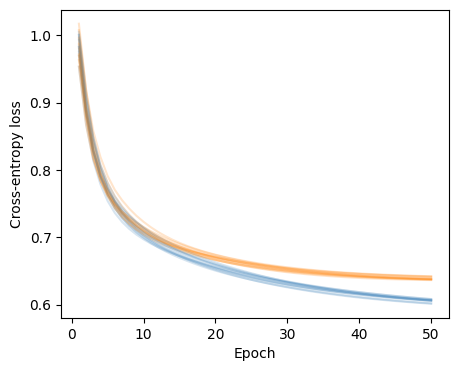

------------------------------ 
Training set:
Average log-likelihood = -4500.2 (10.5)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 73.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -638.8 (1.9)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 72.3% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1305.8 (2.2)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.936 (0.023)
Weak regularity   = 0.960 (0.019)
------------------------------ 
Validation set:
Strong regularity = 0.924 (0.026)
Weak regularity   = 0.957 (0.023)
------------------------------ 
Test set:
Strong regularity = 0.942 (0.021)
Weak regularity   = 0.966 (0.019)
------------------------------


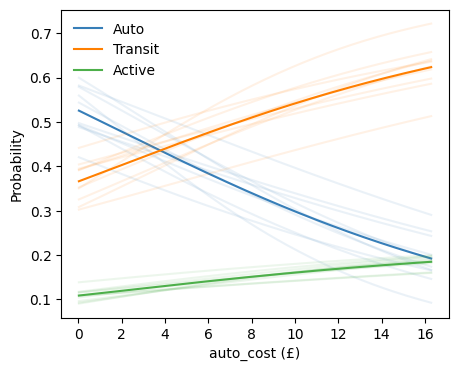

In [56]:
result(TasteNet, 50, 'none')

### PGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -6538.0 | acc = 59.4% | F1 = 56.1%
Validation set: LL = -917.0  | acc = 60.7% | F1 = 57.0%
Test set:       LL = -1867.8 | acc = 58.6% | F1 = 54.9%
Model 2 
Training set:   LL = -6318.8 | acc = 62.6% | F1 = 57.2%
Validation set: LL = -881.0  | acc = 64.3% | F1 = 58.6%
Test set:       LL = -1802.7 | acc = 62.2% | F1 = 56.6%
Model 3 
Training set:   LL = -7807.9 | acc = 35.7% | F1 = 29.6%
Validation set: LL = -1103.2 | acc = 36.8% | F1 = 30.5%
Test set:       LL = -2280.9 | acc = 34.6% | F1 = 28.9%
Model 4 
Training set:   LL = -7490.3 | acc = 47.0% | F1 = 34.8%
Validation set: LL = -1049.3 | acc = 47.0% | F1 = 34.8%
Test set:       LL = -2128.5 | acc = 48.4% | F1 = 36.3%
Model 5 
Training set:   LL = -6391.2 | acc = 60.5% | F1 = 54.6%
Validation set: LL = -893.4  | acc = 61.7% | F1 = 55.7%
Test set:       LL = -1831.3 | acc = 61.3% | F1 = 55.4%
Model 6 
Training set:   LL = -7794.3 | acc = 46.0% | F1 = 34.3%
Valida

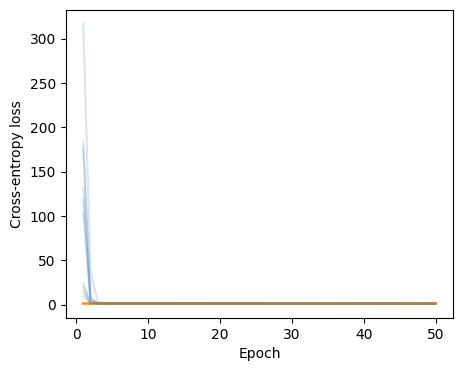

------------------------------ 
Training set:
Average log-likelihood = -7255.0 (601.2)
Average accuracy       = 47.6% (9.8%)
Average F1 score       = 41.6% (10.5%)
------------------------------ 
Validation set:
Average log-likelihood = -1022.9 (91.8)
Average accuracy       = 48.4% (10.2%)
Average F1 score       = 42.5% (11.0%)
------------------------------ 
Test set:
Average log-likelihood = -2082.6 (185.2)
Average accuracy       = 47.4% (10.5%)
Average F1 score       = 41.6% (10.6%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


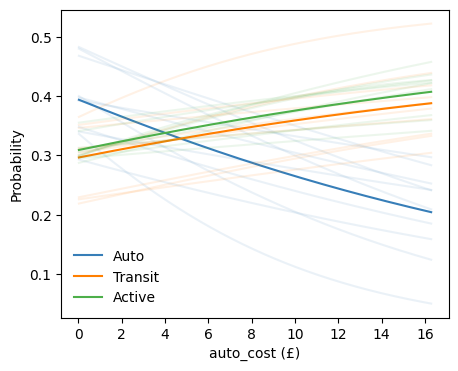

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5522.7 | acc = 65.8% | F1 = 61.9%
Validation set: LL = -771.3  | acc = 66.5% | F1 = 62.0%
Test set:       LL = -1578.5 | acc = 65.5% | F1 = 61.5%
Model 2 
Training set:   LL = -5387.9 | acc = 66.3% | F1 = 62.6%
Validation set: LL = -754.4  | acc = 68.6% | F1 = 64.4%
Test set:       LL = -1536.1 | acc = 65.8% | F1 = 61.7%
Model 3 
Training set:   LL = -6099.2 | acc = 63.1% | F1 = 56.6%
Validation set: LL = -853.2  | acc = 64.2% | F1 = 57.8%
Test set:       LL = -1743.3 | acc = 63.2% | F1 = 56.7%
Model 4 
Training set:   LL = -5896.5 | acc = 63.4% | F1 = 58.9%
Validation set: LL = -836.2  | acc = 65.0% | F1 = 61.0%
Test set:       LL = -1683.6 | acc = 63.1% | F1 = 58.6%
Model 5 
Training set:   LL = -5548.8 | acc = 65.7% | F1 = 61.3%
Validation set: LL = -777.6  | acc = 66.6% | F1 = 61.8%
Test set:       LL = -1587.2 | acc = 65.2% | F1 = 60.9%
Model 6 
Training set:   LL = -5955.8 | acc = 64.4% | F1 = 61.2%
Validat

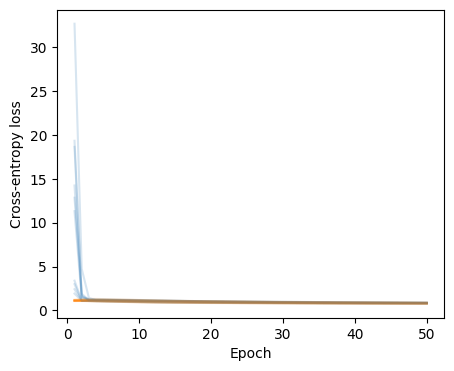

------------------------------ 
Training set:
Average log-likelihood = -5778.7 (262.3)
Average accuracy       = 64.5% (1.6%)
Average F1 score       = 60.5% (1.7%)
------------------------------ 
Validation set:
Average log-likelihood = -813.7 (41.3)
Average accuracy       = 65.6% (1.9%)
Average F1 score       = 61.5% (1.7%)
------------------------------ 
Test set:
Average log-likelihood = -1652.3 (78.7)
Average accuracy       = 63.9% (1.6%)
Average F1 score       = 59.9% (1.6%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


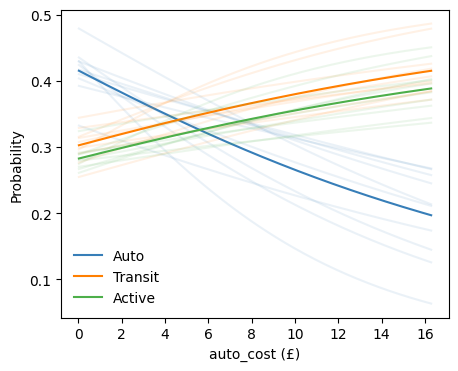

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4964.3 | acc = 70.3% | F1 = 69.2%
Validation set: LL = -695.1  | acc = 71.6% | F1 = 70.2%
Test set:       LL = -1424.5 | acc = 71.2% | F1 = 70.2%
Model 2 
Training set:   LL = -4875.8 | acc = 71.0% | F1 = 70.0%
Validation set: LL = -686.2  | acc = 70.5% | F1 = 69.2%
Test set:       LL = -1403.4 | acc = 71.3% | F1 = 70.4%
Model 3 
Training set:   LL = -5191.4 | acc = 69.8% | F1 = 68.5%
Validation set: LL = -726.7  | acc = 71.1% | F1 = 69.8%
Test set:       LL = -1479.4 | acc = 70.2% | F1 = 69.0%
Model 4 
Training set:   LL = -5116.3 | acc = 69.3% | F1 = 67.8%
Validation set: LL = -719.2  | acc = 69.2% | F1 = 67.5%
Test set:       LL = -1462.9 | acc = 69.9% | F1 = 68.5%
Model 5 
Training set:   LL = -4981.4 | acc = 70.0% | F1 = 68.6%
Validation set: LL = -700.6  | acc = 70.8% | F1 = 69.1%
Test set:       LL = -1433.3 | acc = 70.5% | F1 = 69.2%
Model 6 
Training set:   LL = -5087.3 | acc = 69.9% | F1 = 68.3%
Valid

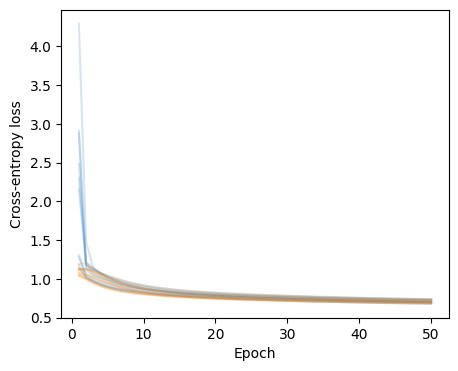

------------------------------ 
Training set:
Average log-likelihood = -5025.4 (113.2)
Average accuracy       = 70.0% (0.7%)
Average F1 score       = 68.6% (1.0%)
------------------------------ 
Validation set:
Average log-likelihood = -705.3 (15.8)
Average accuracy       = 70.2% (1.2%)
Average F1 score       = 68.6% (1.7%)
------------------------------ 
Test set:
Average log-likelihood = -1438.7 (30.3)
Average accuracy       = 70.4% (0.9%)
Average F1 score       = 69.2% (1.3%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------


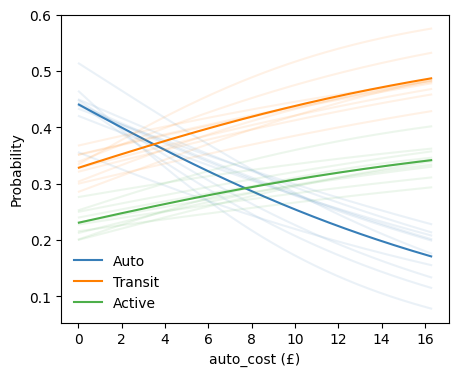

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4580.8 | acc = 72.5% | F1 = 72.0%
Validation set: LL = -647.2  | acc = 72.5% | F1 = 71.8%
Test set:       LL = -1319.9 | acc = 72.7% | F1 = 72.1%
Model 2 
Training set:   LL = -4584.1 | acc = 72.7% | F1 = 72.1%
Validation set: LL = -647.3  | acc = 72.3% | F1 = 71.6%
Test set:       LL = -1327.4 | acc = 72.7% | F1 = 72.1%
Model 3 
Training set:   LL = -4714.0 | acc = 71.1% | F1 = 70.3%
Validation set: LL = -664.7  | acc = 71.8% | F1 = 70.9%
Test set:       LL = -1351.4 | acc = 72.0% | F1 = 71.3%
Model 4 
Training set:   LL = -4660.7 | acc = 71.9% | F1 = 71.2%
Validation set: LL = -656.6  | acc = 72.2% | F1 = 71.3%
Test set:       LL = -1337.2 | acc = 72.0% | F1 = 71.4%
Model 5 
Training set:   LL = -4597.0 | acc = 72.3% | F1 = 71.6%
Validation set: LL = -649.0  | acc = 72.4% | F1 = 71.6%
Test set:       LL = -1330.3 | acc = 72.5% | F1 = 71.9%
Model 6 
Training set:   LL = -4650.9 | acc = 72.3% | F1 = 71.7%
Vali

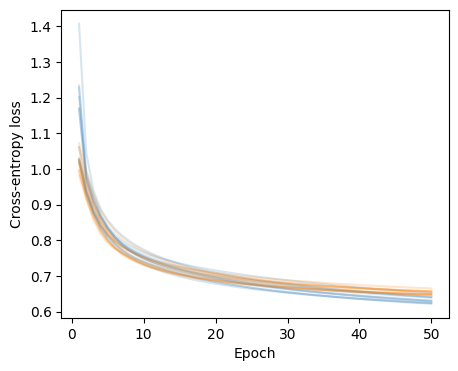

------------------------------ 
Training set:
Average log-likelihood = -4626.4 (42.5)
Average accuracy       = 72.2% (0.5%)
Average F1 score       = 71.6% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -652.7 (5.7)
Average accuracy       = 72.3% (0.3%)
Average F1 score       = 71.6% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1331.7 (9.0)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 71.8% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.984 (0.017)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.977 (0.019)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.982 (0.017)
Weak regularity   = 1.000 (0.000)
------------------------------


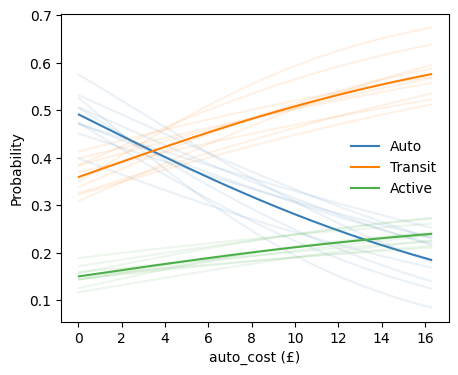

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4499.1 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -639.5  | acc = 72.9% | F1 = 72.3%
Test set:       LL = -1304.8 | acc = 73.2% | F1 = 72.7%
Model 2 
Training set:   LL = -4520.2 | acc = 73.5% | F1 = 73.1%
Validation set: LL = -638.5  | acc = 72.9% | F1 = 72.4%
Test set:       LL = -1311.7 | acc = 72.9% | F1 = 72.4%
Model 3 
Training set:   LL = -4535.2 | acc = 73.1% | F1 = 72.6%
Validation set: LL = -640.7  | acc = 72.7% | F1 = 72.1%
Test set:       LL = -1309.7 | acc = 73.0% | F1 = 72.5%
Model 4 
Training set:   LL = -4530.7 | acc = 73.0% | F1 = 72.5%
Validation set: LL = -639.4  | acc = 72.7% | F1 = 72.1%
Test set:       LL = -1311.2 | acc = 72.8% | F1 = 72.3%
Model 5 
Training set:   LL = -4513.0 | acc = 73.3% | F1 = 72.8%
Validation set: LL = -638.8  | acc = 72.3% | F1 = 71.7%
Test set:       LL = -1310.3 | acc = 72.9% | F1 = 72.5%
Model 6 
Training set:   LL = -4523.5 | acc = 73.3% | F1 = 72.9%
Val

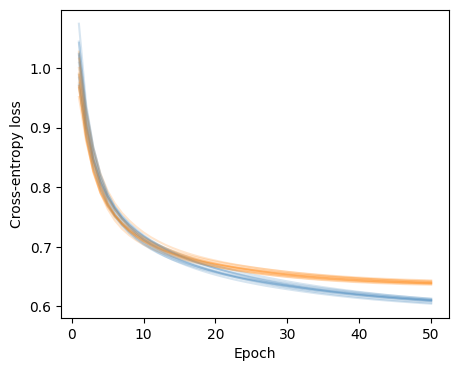

------------------------------ 
Training set:
Average log-likelihood = -4517.9 (12.0)
Average accuracy       = 73.4% (0.2%)
Average F1 score       = 73.0% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -639.9 (2.2)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 72.0% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1308.6 (2.8)
Average accuracy       = 73.0% (0.2%)
Average F1 score       = 72.6% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.964 (0.012)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.953 (0.014)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.964 (0.013)
Weak regularity   = 1.000 (0.000)
------------------------------


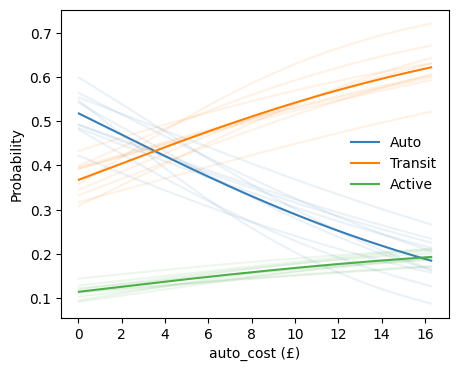

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4485.1 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -638.2  | acc = 73.2% | F1 = 72.6%
Test set:       LL = -1303.1 | acc = 73.2% | F1 = 72.8%
Model 2 
Training set:   LL = -4507.3 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -636.8  | acc = 73.0% | F1 = 72.5%
Test set:       LL = -1309.6 | acc = 73.2% | F1 = 72.8%
Model 3 
Training set:   LL = -4505.3 | acc = 73.5% | F1 = 73.1%
Validation set: LL = -637.6  | acc = 72.8% | F1 = 72.2%
Test set:       LL = -1304.9 | acc = 73.1% | F1 = 72.7%
Model 4 
Training set:   LL = -4508.6 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -636.7  | acc = 73.2% | F1 = 72.6%
Test set:       LL = -1306.5 | acc = 72.8% | F1 = 72.3%
Model 5 
Training set:   LL = -4497.2 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -637.4  | acc = 72.3% | F1 = 71.8%
Test set:       LL = -1307.2 | acc = 73.2% | F1 = 72.8%
Model 6 
Training set:   LL = -4503.9 | acc = 73.6% | F1 = 73.2%
Va

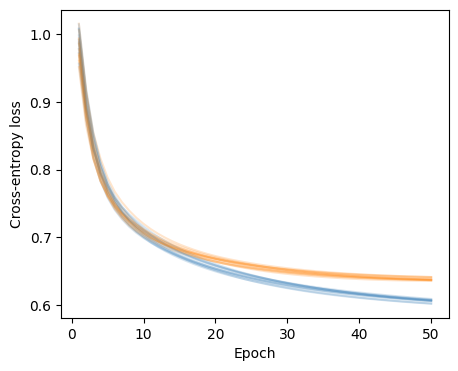

------------------------------ 
Training set:
Average log-likelihood = -4499.6 (10.2)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 73.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -638.2 (2.0)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 72.2% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1305.4 (2.4)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.943 (0.017)
Weak regularity   = 0.982 (0.016)
------------------------------ 
Validation set:
Strong regularity = 0.931 (0.021)
Weak regularity   = 0.981 (0.018)
------------------------------ 
Test set:
Strong regularity = 0.946 (0.018)
Weak regularity   = 0.984 (0.015)
------------------------------


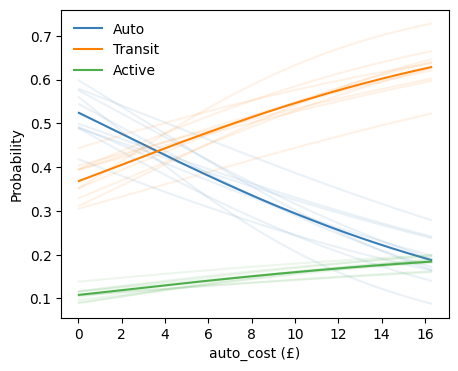

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4484.2 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -638.7  | acc = 73.1% | F1 = 72.5%
Test set:       LL = -1303.6 | acc = 73.0% | F1 = 72.6%
Model 2 
Training set:   LL = -4507.8 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.4  | acc = 73.2% | F1 = 72.7%
Test set:       LL = -1309.7 | acc = 73.2% | F1 = 72.7%
Model 3 
Training set:   LL = -4504.3 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.8  | acc = 73.1% | F1 = 72.5%
Test set:       LL = -1305.3 | acc = 73.2% | F1 = 72.7%
Model 4 
Training set:   LL = -4507.8 | acc = 73.5% | F1 = 73.1%
Validation set: LL = -637.0  | acc = 73.1% | F1 = 72.5%
Test set:       LL = -1306.7 | acc = 72.7% | F1 = 72.2%
Model 5 
Training set:   LL = -4497.7 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -638.0  | acc = 72.3% | F1 = 71.8%
Test set:       LL = -1307.6 | acc = 73.1% | F1 = 72.7%
Model 6 
Training set:   LL = -4504.1 | acc = 73.7% | F1 = 73.3%
Val

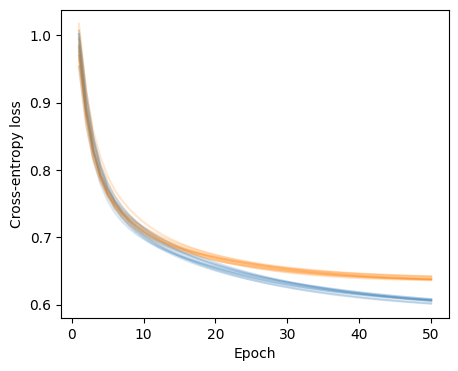

------------------------------ 
Training set:
Average log-likelihood = -4499.7 (10.4)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 73.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -638.7 (2.0)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 72.3% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1305.6 (2.2)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.936 (0.023)
Weak regularity   = 0.961 (0.019)
------------------------------ 
Validation set:
Strong regularity = 0.923 (0.026)
Weak regularity   = 0.958 (0.022)
------------------------------ 
Test set:
Strong regularity = 0.941 (0.021)
Weak regularity   = 0.966 (0.019)
------------------------------


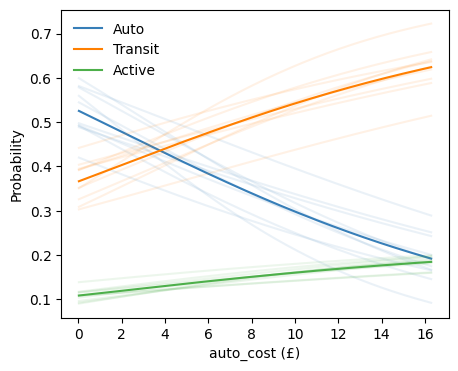

------------------------------ 
Model comparison:


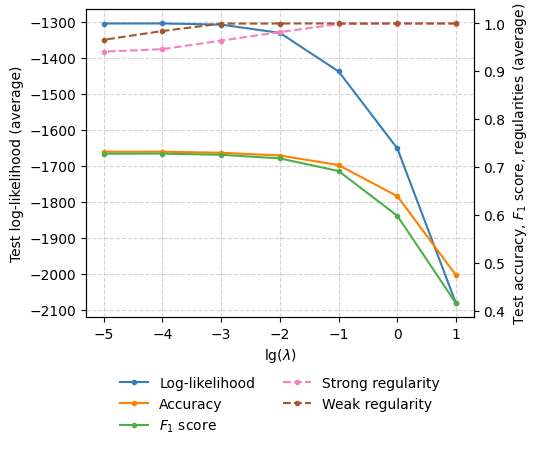

In [57]:
result(TasteNet, 50, 'PGR', [10**i for i in range(1, -6, -1)])

### UGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5687.9 | acc = 63.5% | F1 = 59.8%
Validation set: LL = -794.8  | acc = 65.0% | F1 = 60.6%
Test set:       LL = -1629.3 | acc = 62.7% | F1 = 58.7%
Model 2 
Training set:   LL = -5647.1 | acc = 63.2% | F1 = 58.1%
Validation set: LL = -785.0  | acc = 65.2% | F1 = 59.5%
Test set:       LL = -1619.1 | acc = 62.6% | F1 = 56.9%
Model 3 
Training set:   LL = -5923.3 | acc = 60.6% | F1 = 55.0%
Validation set: LL = -823.8  | acc = 61.5% | F1 = 55.9%
Test set:       LL = -1695.1 | acc = 59.0% | F1 = 53.0%
Model 4 
Training set:   LL = -5631.6 | acc = 64.5% | F1 = 60.3%
Validation set: LL = -788.3  | acc = 66.4% | F1 = 61.7%
Test set:       LL = -1615.1 | acc = 63.2% | F1 = 58.6%
Model 5 
Training set:   LL = -5702.6 | acc = 63.1% | F1 = 58.1%
Validation set: LL = -796.9  | acc = 64.4% | F1 = 58.9%
Test set:       LL = -1635.6 | acc = 62.7% | F1 = 57.5%
Model 6 
Training set:   LL = -5770.7 | acc = 62.2% | F1 = 57.1%
Valida

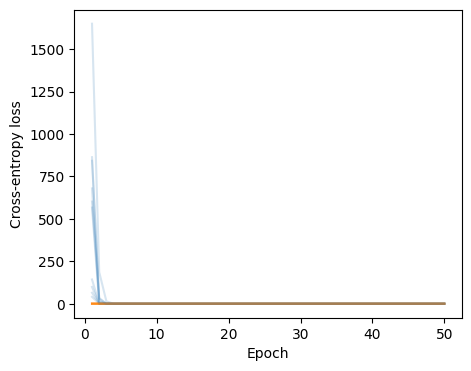

------------------------------ 
Training set:
Average log-likelihood = -5741.5 (81.9)
Average accuracy       = 62.7% (1.0%)
Average F1 score       = 57.8% (1.6%)
------------------------------ 
Validation set:
Average log-likelihood = -800.3 (11.1)
Average accuracy       = 64.2% (1.3%)
Average F1 score       = 58.9% (1.7%)
------------------------------ 
Test set:
Average log-likelihood = -1646.9 (23.6)
Average accuracy       = 61.7% (1.3%)
Average F1 score       = 56.5% (1.9%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


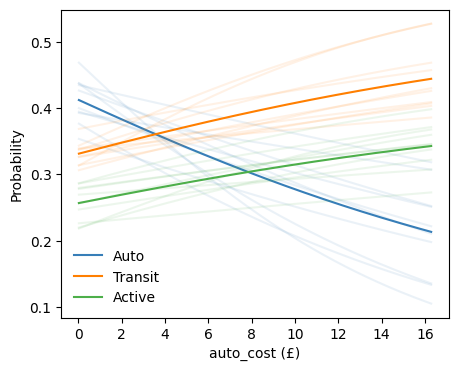

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5589.2 | acc = 64.6% | F1 = 60.9%
Validation set: LL = -783.1  | acc = 65.9% | F1 = 61.6%
Test set:       LL = -1601.9 | acc = 63.7% | F1 = 59.9%
Model 2 
Training set:   LL = -5489.4 | acc = 65.7% | F1 = 62.0%
Validation set: LL = -766.5  | acc = 67.3% | F1 = 62.7%
Test set:       LL = -1573.2 | acc = 65.0% | F1 = 60.8%
Model 3 
Training set:   LL = -5782.3 | acc = 62.4% | F1 = 57.0%
Validation set: LL = -804.2  | acc = 63.6% | F1 = 57.9%
Test set:       LL = -1648.6 | acc = 61.6% | F1 = 55.7%
Model 4 
Training set:   LL = -5587.6 | acc = 64.8% | F1 = 60.8%
Validation set: LL = -782.6  | acc = 66.6% | F1 = 62.1%
Test set:       LL = -1602.6 | acc = 63.8% | F1 = 59.4%
Model 5 
Training set:   LL = -5617.2 | acc = 64.0% | F1 = 59.5%
Validation set: LL = -786.5  | acc = 65.0% | F1 = 59.8%
Test set:       LL = -1612.2 | acc = 64.0% | F1 = 59.6%
Model 6 
Training set:   LL = -5715.5 | acc = 63.4% | F1 = 59.1%
Validat

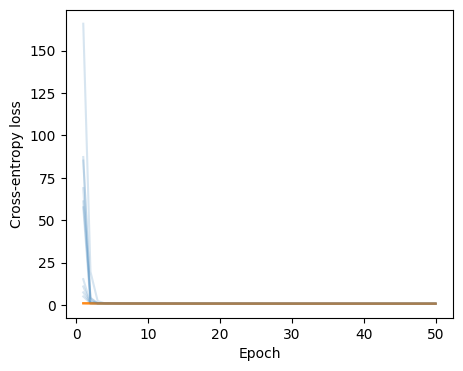

------------------------------ 
Training set:
Average log-likelihood = -5651.5 (85.4)
Average accuracy       = 64.0% (1.0%)
Average F1 score       = 59.6% (1.7%)
------------------------------ 
Validation set:
Average log-likelihood = -788.9 (11.6)
Average accuracy       = 65.3% (1.3%)
Average F1 score       = 60.4% (1.8%)
------------------------------ 
Test set:
Average log-likelihood = -1620.3 (24.0)
Average accuracy       = 63.1% (1.2%)
Average F1 score       = 58.4% (1.9%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


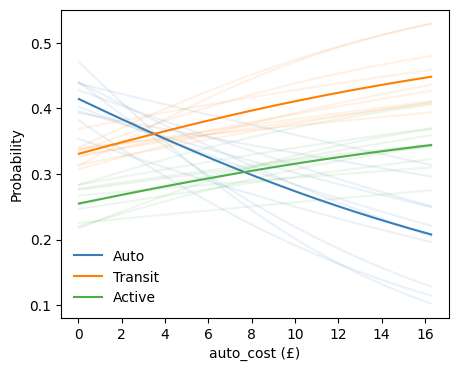

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5270.0 | acc = 66.9% | F1 = 63.8%
Validation set: LL = -738.1  | acc = 68.7% | F1 = 65.0%
Test set:       LL = -1512.0 | acc = 66.3% | F1 = 63.0%
Model 2 
Training set:   LL = -5133.4 | acc = 68.6% | F1 = 66.5%
Validation set: LL = -720.5  | acc = 69.2% | F1 = 66.5%
Test set:       LL = -1473.7 | acc = 68.2% | F1 = 65.9%
Model 3 
Training set:   LL = -5482.1 | acc = 66.8% | F1 = 63.7%
Validation set: LL = -766.0  | acc = 67.4% | F1 = 63.6%
Test set:       LL = -1565.5 | acc = 65.8% | F1 = 62.3%
Model 4 
Training set:   LL = -5366.7 | acc = 66.8% | F1 = 63.7%
Validation set: LL = -752.3  | acc = 67.9% | F1 = 63.9%
Test set:       LL = -1538.0 | acc = 66.1% | F1 = 62.8%
Model 5 
Training set:   LL = -5295.3 | acc = 67.9% | F1 = 65.3%
Validation set: LL = -742.8  | acc = 68.9% | F1 = 66.0%
Test set:       LL = -1522.3 | acc = 67.8% | F1 = 65.2%
Model 6 
Training set:   LL = -5417.1 | acc = 66.1% | F1 = 62.6%
Valid

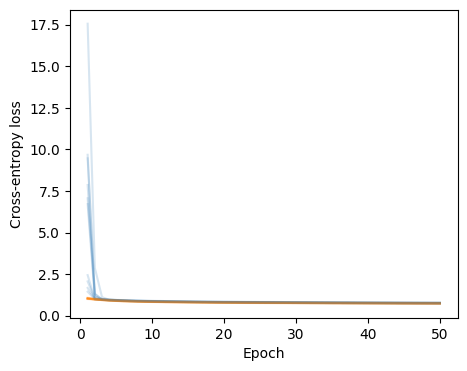

------------------------------ 
Training set:
Average log-likelihood = -5324.2 (109.0)
Average accuracy       = 67.2% (0.9%)
Average F1 score       = 64.4% (1.5%)
------------------------------ 
Validation set:
Average log-likelihood = -745.1 (15.1)
Average accuracy       = 68.0% (0.9%)
Average F1 score       = 64.5% (1.5%)
------------------------------ 
Test set:
Average log-likelihood = -1526.1 (29.9)
Average accuracy       = 66.6% (1.2%)
Average F1 score       = 63.6% (1.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


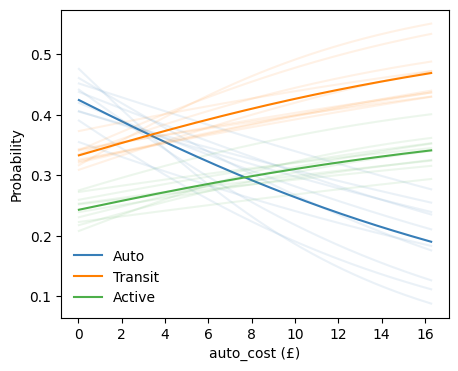

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4785.9 | acc = 71.0% | F1 = 70.2%
Validation set: LL = -671.6  | acc = 72.0% | F1 = 70.9%
Test set:       LL = -1375.9 | acc = 71.4% | F1 = 70.5%
Model 2 
Training set:   LL = -4748.5 | acc = 71.3% | F1 = 70.4%
Validation set: LL = -669.6  | acc = 71.5% | F1 = 70.5%
Test set:       LL = -1370.7 | acc = 71.7% | F1 = 71.0%
Model 3 
Training set:   LL = -5003.1 | acc = 70.2% | F1 = 69.1%
Validation set: LL = -702.0  | acc = 70.6% | F1 = 69.4%
Test set:       LL = -1431.8 | acc = 70.8% | F1 = 69.8%
Model 4 
Training set:   LL = -4924.4 | acc = 70.2% | F1 = 69.2%
Validation set: LL = -691.2  | acc = 70.4% | F1 = 69.2%
Test set:       LL = -1411.9 | acc = 70.9% | F1 = 70.0%
Model 5 
Training set:   LL = -4819.2 | acc = 70.5% | F1 = 69.4%
Validation set: LL = -679.2  | acc = 71.4% | F1 = 70.2%
Test set:       LL = -1391.8 | acc = 70.8% | F1 = 69.8%
Model 6 
Training set:   LL = -4907.6 | acc = 70.5% | F1 = 69.4%
Vali

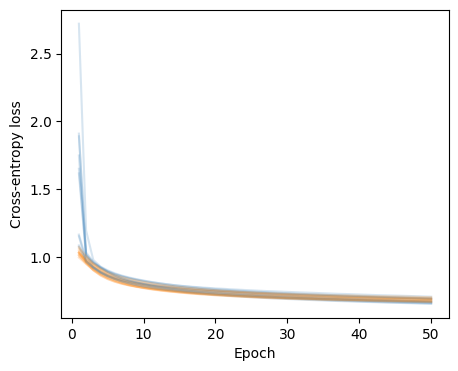

------------------------------ 
Training set:
Average log-likelihood = -4850.0 (87.6)
Average accuracy       = 70.7% (0.4%)
Average F1 score       = 69.7% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -681.3 (11.4)
Average accuracy       = 71.2% (0.6%)
Average F1 score       = 70.1% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1392.4 (22.6)
Average accuracy       = 71.1% (0.5%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.007)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.995 (0.009)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.006)
Weak regularity   = 1.000 (0.000)
------------------------------


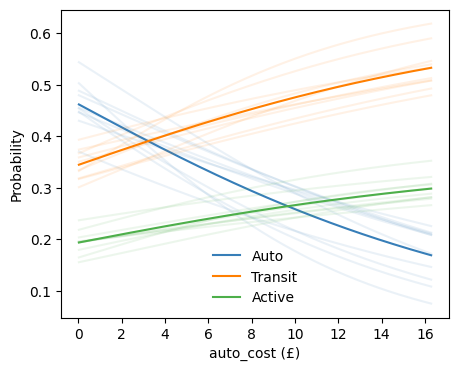

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4533.3 | acc = 73.2% | F1 = 72.8%
Validation set: LL = -642.4  | acc = 72.8% | F1 = 72.2%
Test set:       LL = -1309.5 | acc = 73.0% | F1 = 72.5%
Model 2 
Training set:   LL = -4550.1 | acc = 73.2% | F1 = 72.7%
Validation set: LL = -642.4  | acc = 72.7% | F1 = 72.1%
Test set:       LL = -1318.0 | acc = 72.8% | F1 = 72.3%
Model 3 
Training set:   LL = -4618.5 | acc = 72.1% | F1 = 71.4%
Validation set: LL = -651.8  | acc = 72.2% | F1 = 71.4%
Test set:       LL = -1326.2 | acc = 72.4% | F1 = 71.8%
Model 4 
Training set:   LL = -4592.3 | acc = 72.5% | F1 = 72.0%
Validation set: LL = -647.2  | acc = 72.9% | F1 = 72.1%
Test set:       LL = -1321.7 | acc = 72.0% | F1 = 71.5%
Model 5 
Training set:   LL = -4552.7 | acc = 72.8% | F1 = 72.2%
Validation set: LL = -643.1  | acc = 72.5% | F1 = 71.8%
Test set:       LL = -1319.2 | acc = 72.9% | F1 = 72.4%
Model 6 
Training set:   LL = -4583.0 | acc = 72.7% | F1 = 72.2%
Val

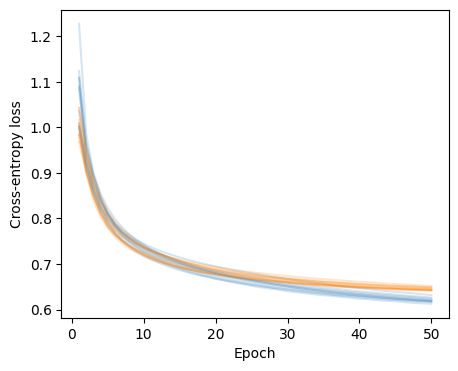

------------------------------ 
Training set:
Average log-likelihood = -4567.1 (24.1)
Average accuracy       = 72.8% (0.4%)
Average F1 score       = 72.3% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -645.3 (3.3)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 71.9% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1317.6 (4.3)
Average accuracy       = 72.8% (0.4%)
Average F1 score       = 72.3% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.988 (0.009)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.982 (0.011)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.987 (0.008)
Weak regularity   = 1.000 (0.000)
------------------------------


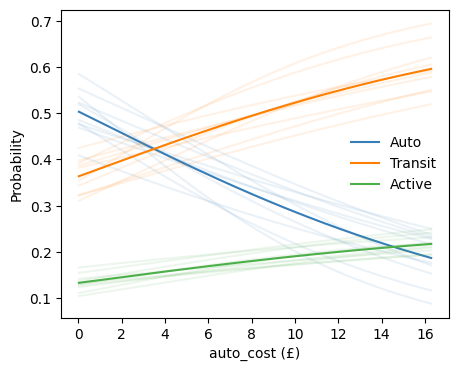

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4492.8 | acc = 73.7% | F1 = 73.3%
Validation set: LL = -638.9  | acc = 72.8% | F1 = 72.2%
Test set:       LL = -1303.8 | acc = 73.2% | F1 = 72.8%
Model 2 
Training set:   LL = -4514.2 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.3  | acc = 73.1% | F1 = 72.6%
Test set:       LL = -1310.3 | acc = 73.0% | F1 = 72.6%
Model 3 
Training set:   LL = -4519.3 | acc = 73.3% | F1 = 72.9%
Validation set: LL = -638.9  | acc = 72.8% | F1 = 72.2%
Test set:       LL = -1306.5 | acc = 72.9% | F1 = 72.4%
Model 4 
Training set:   LL = -4519.6 | acc = 73.2% | F1 = 72.8%
Validation set: LL = -638.1  | acc = 72.8% | F1 = 72.2%
Test set:       LL = -1309.1 | acc = 72.5% | F1 = 72.1%
Model 5 
Training set:   LL = -4504.7 | acc = 73.3% | F1 = 72.9%
Validation set: LL = -637.9  | acc = 72.3% | F1 = 71.7%
Test set:       LL = -1308.8 | acc = 73.0% | F1 = 72.5%
Model 6 
Training set:   LL = -4513.3 | acc = 73.4% | F1 = 73.0%
Va

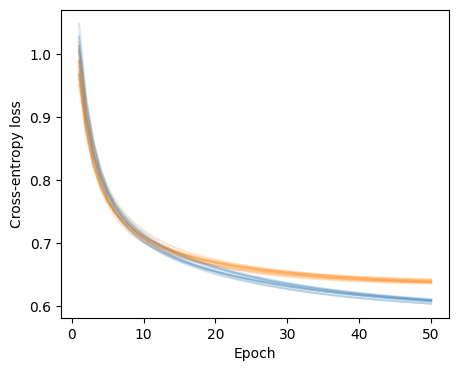

------------------------------ 
Training set:
Average log-likelihood = -4508.5 (10.7)
Average accuracy       = 73.5% (0.2%)
Average F1 score       = 73.1% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -638.8 (2.0)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 72.1% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1306.9 (2.7)
Average accuracy       = 73.0% (0.3%)
Average F1 score       = 72.6% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.966 (0.013)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.956 (0.015)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.966 (0.014)
Weak regularity   = 1.000 (0.000)
------------------------------


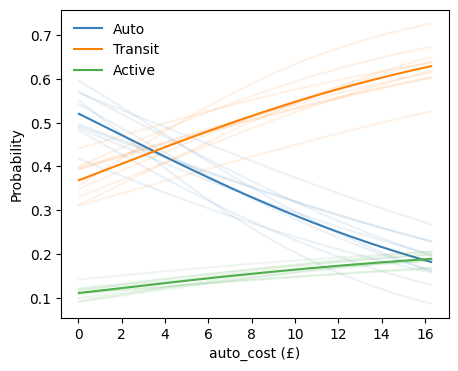

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4484.2 | acc = 73.9% | F1 = 73.5%
Validation set: LL = -638.1  | acc = 73.2% | F1 = 72.6%
Test set:       LL = -1302.7 | acc = 73.2% | F1 = 72.8%
Model 2 
Training set:   LL = -4507.1 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -636.7  | acc = 73.2% | F1 = 72.7%
Test set:       LL = -1309.3 | acc = 73.2% | F1 = 72.8%
Model 3 
Training set:   LL = -4504.2 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.5  | acc = 73.0% | F1 = 72.4%
Test set:       LL = -1304.8 | acc = 73.2% | F1 = 72.8%
Model 4 
Training set:   LL = -4507.4 | acc = 73.5% | F1 = 73.1%
Validation set: LL = -636.7  | acc = 73.2% | F1 = 72.6%
Test set:       LL = -1306.3 | acc = 72.7% | F1 = 72.3%
Model 5 
Training set:   LL = -4496.7 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -637.4  | acc = 72.4% | F1 = 71.9%
Test set:       LL = -1306.9 | acc = 73.2% | F1 = 72.8%
Model 6 
Training set:   LL = -4503.4 | acc = 73.6% | F1 = 73.2%
Val

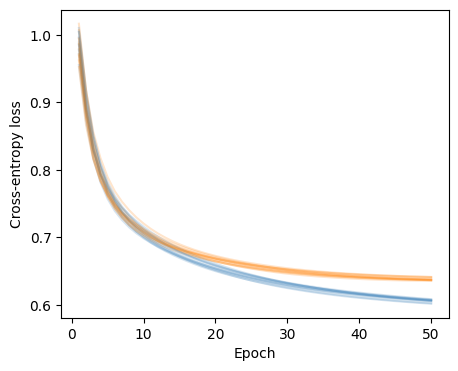

------------------------------ 
Training set:
Average log-likelihood = -4499.0 (10.2)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 73.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -638.1 (2.0)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 72.3% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1305.2 (2.3)
Average accuracy       = 73.3% (0.3%)
Average F1 score       = 72.9% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.017)
Weak regularity   = 0.986 (0.015)
------------------------------ 
Validation set:
Strong regularity = 0.934 (0.020)
Weak regularity   = 0.985 (0.017)
------------------------------ 
Test set:
Strong regularity = 0.950 (0.017)
Weak regularity   = 0.988 (0.015)
------------------------------


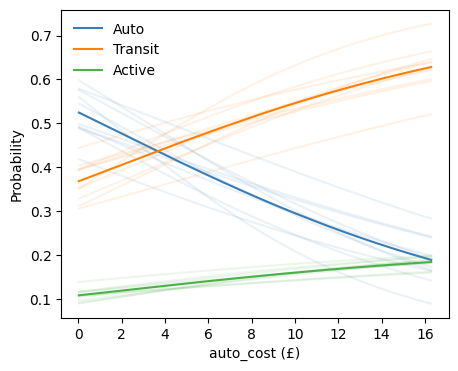

------------------------------ 
Model comparison:


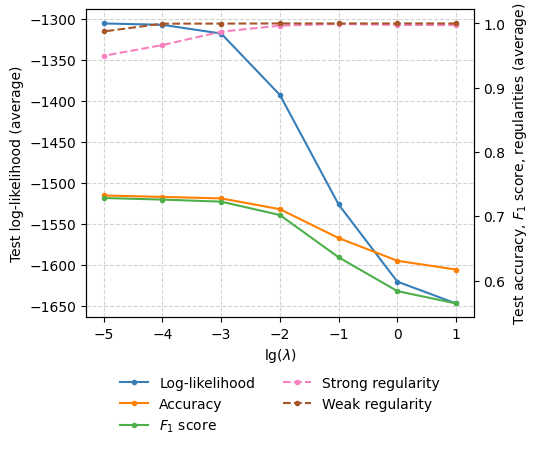

In [58]:
result(TasteNet, 50, 'UGR', [10**i for i in range(1, -6, -1)])

### LGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -6526.9 | acc = 61.1% | F1 = 56.8%
Validation set: LL = -920.4  | acc = 60.7% | F1 = 56.0%
Test set:       LL = -1881.5 | acc = 59.7% | F1 = 55.2%
Model 2 
Training set:   LL = -6329.3 | acc = 61.3% | F1 = 55.9%
Validation set: LL = -887.6  | acc = 62.9% | F1 = 57.6%
Test set:       LL = -1812.3 | acc = 60.4% | F1 = 54.7%
Model 3 
Training set:   LL = -7043.1 | acc = 53.3% | F1 = 45.9%
Validation set: LL = -986.9  | acc = 55.8% | F1 = 49.1%
Test set:       LL = -2014.6 | acc = 54.7% | F1 = 47.5%
Model 4 
Training set:   LL = -6775.1 | acc = 55.3% | F1 = 48.8%
Validation set: LL = -953.3  | acc = 57.4% | F1 = 51.6%
Test set:       LL = -1945.3 | acc = 55.6% | F1 = 49.1%
Model 5 
Training set:   LL = -6257.9 | acc = 60.8% | F1 = 55.0%
Validation set: LL = -877.3  | acc = 63.0% | F1 = 56.8%
Test set:       LL = -1790.4 | acc = 61.0% | F1 = 55.2%
Model 6 
Training set:   LL = -7013.0 | acc = 53.4% | F1 = 49.9%
Valida

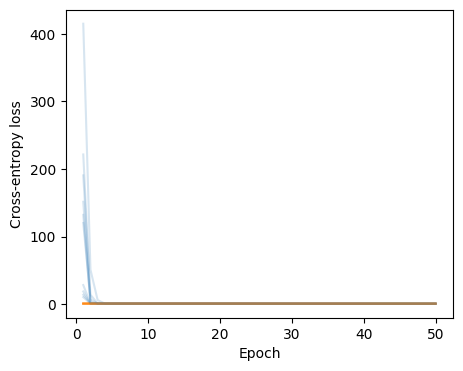

------------------------------ 
Training set:
Average log-likelihood = -6790.5 (336.6)
Average accuracy       = 55.6% (4.6%)
Average F1 score       = 50.0% (4.7%)
------------------------------ 
Validation set:
Average log-likelihood = -957.1 (50.7)
Average accuracy       = 56.7% (4.6%)
Average F1 score       = 51.4% (4.3%)
------------------------------ 
Test set:
Average log-likelihood = -1955.0 (104.1)
Average accuracy       = 54.9% (5.0%)
Average F1 score       = 49.3% (4.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


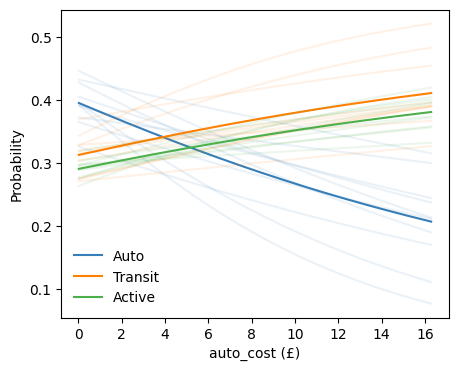

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5514.5 | acc = 66.1% | F1 = 62.4%
Validation set: LL = -771.4  | acc = 67.5% | F1 = 63.3%
Test set:       LL = -1580.8 | acc = 65.1% | F1 = 61.0%
Model 2 
Training set:   LL = -5383.0 | acc = 66.8% | F1 = 63.2%
Validation set: LL = -757.4  | acc = 67.8% | F1 = 63.5%
Test set:       LL = -1536.6 | acc = 66.2% | F1 = 62.2%
Model 3 
Training set:   LL = -6004.2 | acc = 63.3% | F1 = 56.8%
Validation set: LL = -841.8  | acc = 64.9% | F1 = 58.4%
Test set:       LL = -1709.4 | acc = 63.1% | F1 = 56.5%
Model 4 
Training set:   LL = -5768.0 | acc = 64.4% | F1 = 60.2%
Validation set: LL = -818.6  | acc = 64.3% | F1 = 60.0%
Test set:       LL = -1651.4 | acc = 62.9% | F1 = 58.5%
Model 5 
Training set:   LL = -5493.6 | acc = 66.1% | F1 = 62.0%
Validation set: LL = -769.9  | acc = 67.3% | F1 = 62.8%
Test set:       LL = -1572.3 | acc = 66.0% | F1 = 62.1%
Model 6 
Training set:   LL = -6009.9 | acc = 62.7% | F1 = 57.0%
Validat

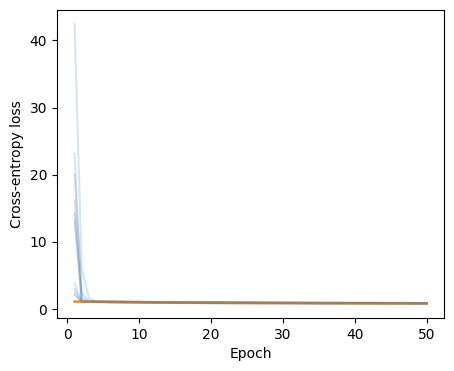

------------------------------ 
Training set:
Average log-likelihood = -5728.3 (247.0)
Average accuracy       = 65.1% (1.3%)
Average F1 score       = 60.6% (2.2%)
------------------------------ 
Validation set:
Average log-likelihood = -807.6 (37.7)
Average accuracy       = 65.8% (1.7%)
Average F1 score       = 61.2% (2.3%)
------------------------------ 
Test set:
Average log-likelihood = -1640.2 (73.0)
Average accuracy       = 64.2% (1.5%)
Average F1 score       = 59.6% (2.3%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


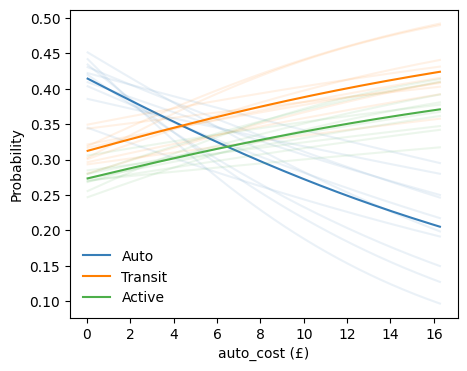

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4954.1 | acc = 70.3% | F1 = 69.3%
Validation set: LL = -693.8  | acc = 71.4% | F1 = 70.2%
Test set:       LL = -1419.8 | acc = 71.0% | F1 = 70.0%
Model 2 
Training set:   LL = -4874.8 | acc = 70.9% | F1 = 70.0%
Validation set: LL = -685.9  | acc = 70.9% | F1 = 69.7%
Test set:       LL = -1401.1 | acc = 71.2% | F1 = 70.3%
Model 3 
Training set:   LL = -5152.3 | acc = 70.0% | F1 = 68.8%
Validation set: LL = -720.9  | acc = 70.5% | F1 = 69.2%
Test set:       LL = -1466.5 | acc = 70.4% | F1 = 69.3%
Model 4 
Training set:   LL = -5099.9 | acc = 68.9% | F1 = 67.3%
Validation set: LL = -719.1  | acc = 69.3% | F1 = 67.4%
Test set:       LL = -1459.7 | acc = 69.4% | F1 = 67.8%
Model 5 
Training set:   LL = -4967.4 | acc = 70.0% | F1 = 68.7%
Validation set: LL = -698.4  | acc = 70.8% | F1 = 69.3%
Test set:       LL = -1429.8 | acc = 70.7% | F1 = 69.5%
Model 6 
Training set:   LL = -5087.5 | acc = 69.3% | F1 = 67.4%
Valid

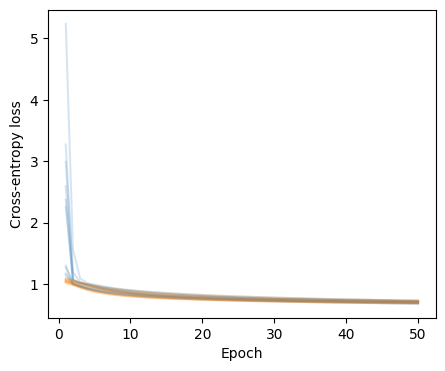

------------------------------ 
Training set:
Average log-likelihood = -5013.5 (102.0)
Average accuracy       = 69.8% (0.7%)
Average F1 score       = 68.5% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -704.5 (14.8)
Average accuracy       = 70.4% (0.9%)
Average F1 score       = 68.8% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -1434.5 (26.9)
Average accuracy       = 70.3% (0.9%)
Average F1 score       = 69.1% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.005)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.007)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.006)
Weak regularity   = 1.000 (0.000)
------------------------------


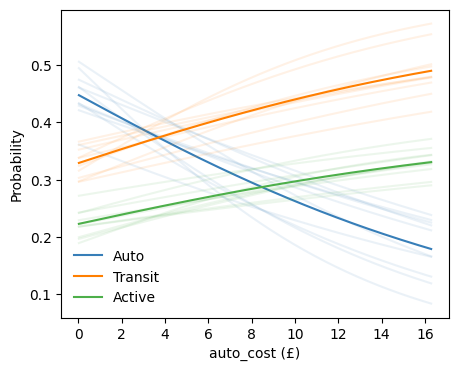

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4577.1 | acc = 72.6% | F1 = 72.0%
Validation set: LL = -647.1  | acc = 72.7% | F1 = 72.0%
Test set:       LL = -1318.2 | acc = 72.9% | F1 = 72.3%
Model 2 
Training set:   LL = -4584.6 | acc = 72.7% | F1 = 72.2%
Validation set: LL = -647.3  | acc = 72.4% | F1 = 71.7%
Test set:       LL = -1326.1 | acc = 72.5% | F1 = 71.9%
Model 3 
Training set:   LL = -4706.6 | acc = 71.4% | F1 = 70.7%
Validation set: LL = -663.0  | acc = 72.2% | F1 = 71.3%
Test set:       LL = -1348.7 | acc = 72.0% | F1 = 71.4%
Model 4 
Training set:   LL = -4671.4 | acc = 71.9% | F1 = 71.2%
Validation set: LL = -657.4  | acc = 71.9% | F1 = 71.0%
Test set:       LL = -1340.2 | acc = 72.0% | F1 = 71.3%
Model 5 
Training set:   LL = -4597.0 | acc = 72.2% | F1 = 71.5%
Validation set: LL = -648.8  | acc = 72.6% | F1 = 71.8%
Test set:       LL = -1329.1 | acc = 72.5% | F1 = 72.0%
Model 6 
Training set:   LL = -4658.0 | acc = 72.5% | F1 = 71.9%
Vali

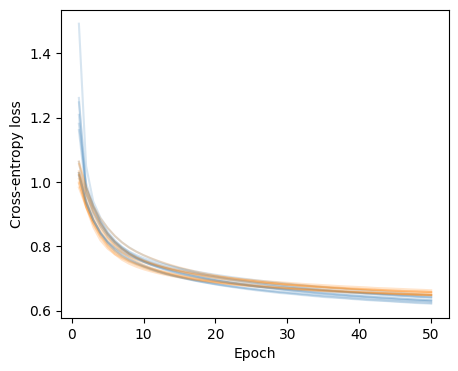

------------------------------ 
Training set:
Average log-likelihood = -4631.0 (41.2)
Average accuracy       = 72.2% (0.5%)
Average F1 score       = 71.6% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -653.1 (5.3)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 71.6% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1331.4 (8.4)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 71.8% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.989 (0.014)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.984 (0.016)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.987 (0.015)
Weak regularity   = 1.000 (0.000)
------------------------------


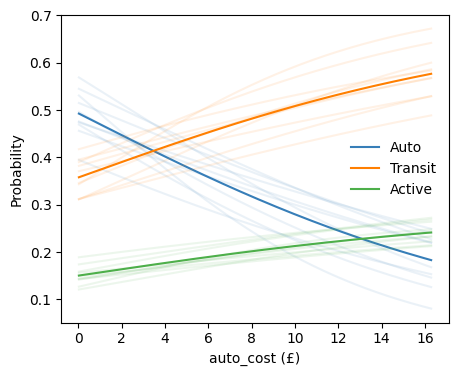

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4498.1 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -639.4  | acc = 72.9% | F1 = 72.4%
Test set:       LL = -1304.6 | acc = 73.0% | F1 = 72.6%
Model 2 
Training set:   LL = -4520.3 | acc = 73.5% | F1 = 73.1%
Validation set: LL = -638.5  | acc = 73.0% | F1 = 72.5%
Test set:       LL = -1311.6 | acc = 72.9% | F1 = 72.4%
Model 3 
Training set:   LL = -4535.4 | acc = 73.2% | F1 = 72.8%
Validation set: LL = -640.7  | acc = 72.6% | F1 = 72.0%
Test set:       LL = -1308.4 | acc = 73.0% | F1 = 72.5%
Model 4 
Training set:   LL = -4531.0 | acc = 73.0% | F1 = 72.6%
Validation set: LL = -639.8  | acc = 72.6% | F1 = 72.0%
Test set:       LL = -1310.8 | acc = 72.8% | F1 = 72.4%
Model 5 
Training set:   LL = -4512.2 | acc = 73.3% | F1 = 72.9%
Validation set: LL = -638.7  | acc = 72.4% | F1 = 71.8%
Test set:       LL = -1310.2 | acc = 72.9% | F1 = 72.4%
Model 6 
Training set:   LL = -4525.7 | acc = 73.3% | F1 = 72.9%
Val

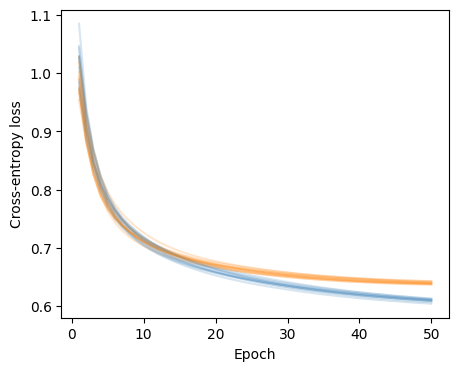

------------------------------ 
Training set:
Average log-likelihood = -4518.7 (11.9)
Average accuracy       = 73.4% (0.2%)
Average F1 score       = 73.0% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -639.9 (2.0)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 72.0% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1308.3 (2.7)
Average accuracy       = 73.0% (0.2%)
Average F1 score       = 72.6% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.975 (0.011)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.964 (0.014)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.972 (0.012)
Weak regularity   = 1.000 (0.000)
------------------------------


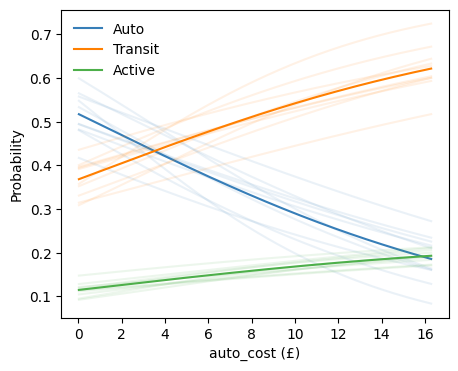

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4485.1 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -638.2  | acc = 73.0% | F1 = 72.4%
Test set:       LL = -1303.1 | acc = 73.2% | F1 = 72.8%
Model 2 
Training set:   LL = -4507.4 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -636.8  | acc = 73.0% | F1 = 72.5%
Test set:       LL = -1309.6 | acc = 73.2% | F1 = 72.8%
Model 3 
Training set:   LL = -4505.4 | acc = 73.5% | F1 = 73.1%
Validation set: LL = -637.5  | acc = 72.9% | F1 = 72.3%
Test set:       LL = -1304.9 | acc = 73.1% | F1 = 72.7%
Model 4 
Training set:   LL = -4508.6 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -636.7  | acc = 73.2% | F1 = 72.6%
Test set:       LL = -1306.5 | acc = 72.8% | F1 = 72.3%
Model 5 
Training set:   LL = -4497.6 | acc = 73.4% | F1 = 73.0%
Validation set: LL = -637.4  | acc = 72.3% | F1 = 71.8%
Test set:       LL = -1307.2 | acc = 73.2% | F1 = 72.8%
Model 6 
Training set:   LL = -4504.1 | acc = 73.6% | F1 = 73.2%
Va

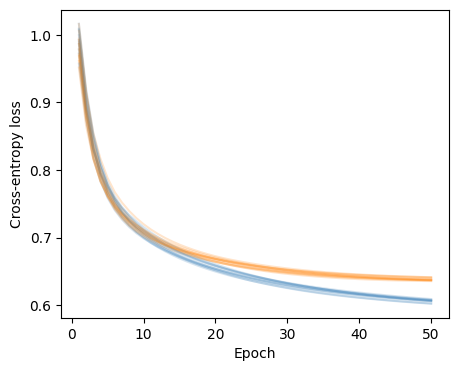

------------------------------ 
Training set:
Average log-likelihood = -4499.9 (10.1)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 73.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -638.1 (1.9)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 72.2% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1305.4 (2.3)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.946 (0.017)
Weak regularity   = 0.986 (0.015)
------------------------------ 
Validation set:
Strong regularity = 0.932 (0.021)
Weak regularity   = 0.986 (0.017)
------------------------------ 
Test set:
Strong regularity = 0.949 (0.018)
Weak regularity   = 0.988 (0.015)
------------------------------


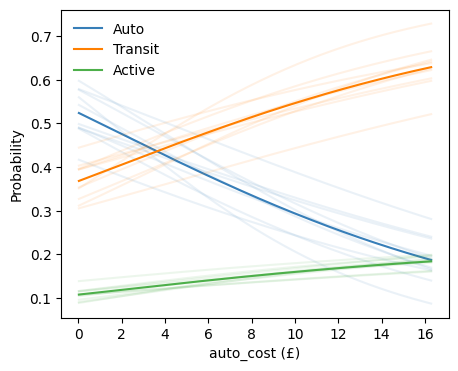

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4484.2 | acc = 73.8% | F1 = 73.4%
Validation set: LL = -638.7  | acc = 73.1% | F1 = 72.5%
Test set:       LL = -1303.6 | acc = 73.0% | F1 = 72.6%
Model 2 
Training set:   LL = -4507.8 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.3  | acc = 73.1% | F1 = 72.6%
Test set:       LL = -1309.7 | acc = 73.2% | F1 = 72.7%
Model 3 
Training set:   LL = -4504.4 | acc = 73.6% | F1 = 73.2%
Validation set: LL = -637.8  | acc = 73.0% | F1 = 72.4%
Test set:       LL = -1305.2 | acc = 73.2% | F1 = 72.7%
Model 4 
Training set:   LL = -4507.8 | acc = 73.6% | F1 = 73.1%
Validation set: LL = -637.0  | acc = 73.0% | F1 = 72.4%
Test set:       LL = -1306.8 | acc = 72.7% | F1 = 72.2%
Model 5 
Training set:   LL = -4497.8 | acc = 73.3% | F1 = 72.9%
Validation set: LL = -638.0  | acc = 72.3% | F1 = 71.8%
Test set:       LL = -1307.5 | acc = 73.1% | F1 = 72.7%
Model 6 
Training set:   LL = -4504.2 | acc = 73.6% | F1 = 73.2%
Val

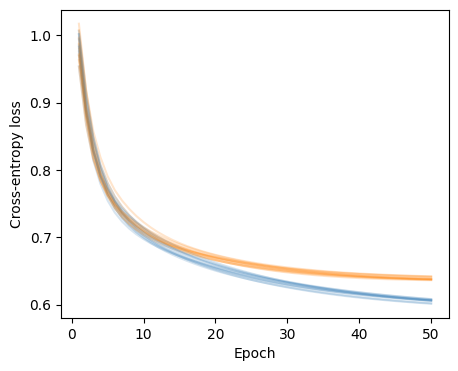

------------------------------ 
Training set:
Average log-likelihood = -4499.7 (10.5)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 73.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -638.7 (2.0)
Average accuracy       = 72.8% (0.2%)
Average F1 score       = 72.2% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1305.6 (2.2)
Average accuracy       = 73.2% (0.3%)
Average F1 score       = 72.8% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.936 (0.022)
Weak regularity   = 0.961 (0.019)
------------------------------ 
Validation set:
Strong regularity = 0.924 (0.026)
Weak regularity   = 0.958 (0.022)
------------------------------ 
Test set:
Strong regularity = 0.942 (0.021)
Weak regularity   = 0.966 (0.019)
------------------------------


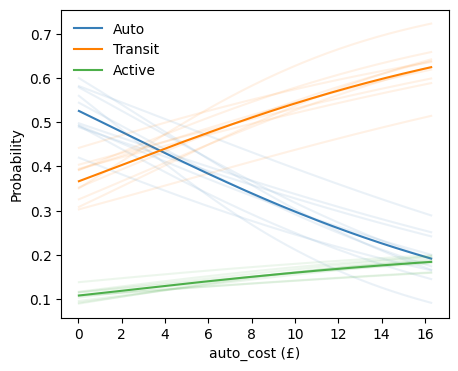

------------------------------ 
Model comparison:


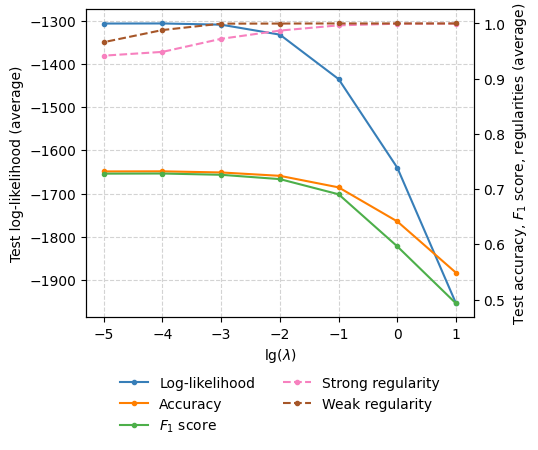

In [59]:
result(TasteNet, 50, 'LGR', [10**i for i in range(1, -6, -1)])

# Final results

In [60]:
weights = np.array([2/val_size, .5, .5, 1, 1])
scores = results_val.multiply(weights, axis=0).sum()
l_col = []
for model in ['DNN', 'TasteNet']:
    l_col.append(model)
    for GR in ['PGR', 'UGR', 'LGR']:
        l_col.append(scores[scores.index.str.startswith(f'{model}, sum-{GR}')].idxmax())
l_col.append('MNL')

In [61]:
results_train = results_train[l_col]
results_val = results_val[l_col].iloc[:5]
results_test = results_test[l_col]

results_train_std = results_train_std[l_col]
results_val_std = results_val_std[l_col]
results_test_std = results_test_std[l_col]

In [67]:
results_train.to_csv(f'{path}/Regularity_results_L/10K_London_train.csv')
results_val.to_csv(f'{path}/Regularity_results_L/10K_London_val.csv')
results_test.to_csv(f'{path}/Regularity_results_L/10K_London_test.csv')

results_train_std.to_csv(f'{path}/Regularity_results_L/10K_London_train_std.csv')
results_val_std.to_csv(f'{path}/Regularity_results_L/10K_London_val_std.csv')
results_test_std.to_csv(f'{path}/Regularity_results_L/10K_London_test_std.csv')

In [62]:
results_train.iloc[0] = results_train.iloc[0].round(1)
results_val.iloc[0] = results_val.iloc[0].round(1)
results_test.iloc[0] = results_test.iloc[0].round(1)

In [63]:
df_train = results_train.round(3).astype(str).add(' (').add(results_train_std.round(3).astype(str)).add(')')
df_val = results_val.round(3).astype(str).add(' (').add(results_val_std.round(3).astype(str)).add(')')
df_test = results_test.round(3).astype(str).add(' (').add(results_test_std.round(3).astype(str)).add(')')

In [64]:
print(df_train.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.01) & DNN, sum-UGR (0.01) & DNN, sum-LGR (0.1) & TasteNet & TasteNet, sum-PGR (0.001) & TasteNet, sum-UGR (0.001) & TasteNet, sum-LGR (0.001) & MNL \\
\midrule
Log-likelihood & -4427.9 (20.613) & -4416.1 (39.091) & -4434.8 (24.414) & -4499.3 (15.996) & -4500.2 (10.521) & -4517.9 (12.028) & -4567.1 (24.142) & -4518.7 (11.933) & -4834.7 (0) \\
Accuracy & 0.732 (0.003) & 0.729 (0.004) & 0.731 (0.005) & 0.729 (0.004) & 0.736 (0.001) & 0.734 (0.002) & 0.728 (0.004) & 0.734 (0.002) & 0.718 (0) \\
F1 score & 0.731 (0.002) & 0.728 (0.003) & 0.73 (0.004) & 0.726 (0.004) & 0.732 (0.001) & 0.73 (0.002) & 0.723 (0.004) & 0.73 (0.002) & 0.714 (0) \\
Strong regularity & 0.947 (0.032) & 0.993 (0.004) & 0.994 (0.009) & 0.997 (0.003) & 0.936 (0.023) & 0.964 (0.012) & 0.988 (0.009) & 0.975 (0.011) & 0.996 (0) \\
Weak regularity & 0.968 (0.025) & 0.999 (0.001) & 0.998 (0.005) & 1.0 (0.0) & 0.96 (0.019) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.0) & 1.0

In [65]:
print(df_val.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.01) & DNN, sum-UGR (0.01) & DNN, sum-LGR (0.1) & TasteNet & TasteNet, sum-PGR (0.001) & TasteNet, sum-UGR (0.001) & TasteNet, sum-LGR (0.001) & MNL \\
\midrule
Log-likelihood & -645.5 (4.399) & -642.8 (5.709) & -644.2 (4.345) & -647.8 (3.915) & -638.8 (1.949) & -639.9 (2.182) & -645.3 (3.254) & -639.9 (1.985) & -670.0 (0) \\
Accuracy & 0.721 (0.002) & 0.722 (0.003) & 0.725 (0.002) & 0.723 (0.005) & 0.729 (0.003) & 0.726 (0.002) & 0.726 (0.002) & 0.726 (0.002) & 0.735 (0) \\
F1 score & 0.719 (0.003) & 0.721 (0.003) & 0.722 (0.002) & 0.718 (0.004) & 0.723 (0.003) & 0.72 (0.002) & 0.719 (0.003) & 0.72 (0.002) & 0.73 (0) \\
Strong regularity & 0.947 (0.032) & 0.992 (0.005) & 0.991 (0.012) & 0.996 (0.004) & 0.924 (0.026) & 0.953 (0.014) & 0.982 (0.011) & 0.964 (0.014) & 0.991 (0) \\
Weak regularity & 0.971 (0.025) & 0.999 (0.001) & 0.997 (0.007) & 1.0 (0.001) & 0.957 (0.023) & 1.0 (0.001) & 1.0 (0.0) & 1.0 (0.001) & 1.0 (0) \\
\b

In [66]:
print(df_test.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.01) & DNN, sum-UGR (0.01) & DNN, sum-LGR (0.1) & TasteNet & TasteNet, sum-PGR (0.001) & TasteNet, sum-UGR (0.001) & TasteNet, sum-LGR (0.001) & MNL \\
\midrule
Log-likelihood & -1292.0 (7.894) & -1288.6 (9.668) & -1288.6 (3.765) & -1305.0 (7.316) & -1305.8 (2.226) & -1308.6 (2.795) & -1317.6 (4.28) & -1308.3 (2.67) & -1366.9 (0) \\
Accuracy & 0.729 (0.005) & 0.729 (0.004) & 0.727 (0.002) & 0.724 (0.004) & 0.732 (0.003) & 0.73 (0.002) & 0.728 (0.004) & 0.73 (0.002) & 0.73 (0) \\
F1 score & 0.727 (0.004) & 0.728 (0.004) & 0.725 (0.002) & 0.721 (0.006) & 0.728 (0.003) & 0.726 (0.002) & 0.723 (0.004) & 0.726 (0.002) & 0.726 (0) \\
Strong regularity & 0.95 (0.034) & 0.994 (0.004) & 0.994 (0.009) & 0.997 (0.003) & 0.942 (0.021) & 0.964 (0.013) & 0.987 (0.008) & 0.972 (0.012) & 0.993 (0) \\
Weak regularity & 0.969 (0.027) & 0.999 (0.001) & 0.998 (0.004) & 1.0 (0.0) & 0.966 (0.019) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0.0) & 1.0 (0) \\
\b